# 1. Data Processing and Feature Engineering (Day 1)

### Import required libraries 

In [ ]:
# Import Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import sklearn metrics and models
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Import Prophet model
from prophet import Prophet

# Import XGBoost model
from xgboost import XGBRegressor

# Import LSTM dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Supress Warnings messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Load and inspect data.

## 1. Data Cleaning

### Load data files

In [5]:
# load the datasets.
train = pd.read_csv("train.csv", parse_dates=['date'])
test=pd.read_csv("test.csv", parse_dates=['date'])
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv", parse_dates=['date'])
holidays = pd.read_csv("holidays_events.csv", parse_dates=['date'])

In [7]:
# cheking missing values in all data sets.
datasets = {
    "Train": train,
    "Test": test,
    "Stores": stores,
    "Oil": oil,
    "Holidays": holidays
}

for name, da in datasets.items():
    print(f"Missing values in {name} dataset:")
    print(df.isnull().sum())
    print("-" * 40)

Missing values in Train dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
----------------------------------------
Missing values in Test dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
----------------------------------------
Missing values in Stores dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
----------------------------------------
Missing values in Oil dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
----------------------------------------
Missing values in Holidays dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
----------------------------------------


In [9]:
# checking data types of all column variables in dataset.
for name, da in datasets.items():
    print(f"Data types in {name} dataset:")
    print(da.dtypes)
    print("-" * 40)

Data types in Train dataset:
id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object
----------------------------------------
Data types in Test dataset:
id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dtype: object
----------------------------------------
Data types in Stores dataset:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
----------------------------------------
Data types in Oil dataset:
date          datetime64[ns]
dcoilwtico           float64
dtype: object
----------------------------------------
Data types in Holidays dataset:
date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            obj

### Handle missing values in oil prices by with linear interpolation method.

In [10]:
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [131]:
oil.tail()

date  dcoilwtico
1213 2017-08-25       47.65
1214 2017-08-28       46.40
1215 2017-08-29       46.46
1216 2017-08-30       45.96
1217 2017-08-31       47.26

In [11]:
# Impute missing oil prices using linear interpolation
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

# As there are missing values in the start/end of the date use "fillna" method to 
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

# Display the first few rows to verify the interpolation
print("Oil dataset after interpolation:")
print(oil.head())

Oil dataset after interpolation:
        date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20


### Convert date columns to proper datetime formats.

In [12]:
# Convert date columns to date-time format.
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
oil['date'] = pd.to_datetime(oil['date'])

### Merge data from stores.csv, oil.csv, and holidays_events.csv into the main dataset.

In [13]:
# merging the data sets of oil, stores, and into train data
train = train.merge(stores, on ='store_nbr', how = 'left')
train = train.merge(oil, on = 'date', how = 'left')
train = train.merge(holidays, on = 'date', how = 'left')

In [14]:
# check new dataframe dtypes after merging.
train.dtypes


id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
city                   object
state                  object
type_x                 object
cluster                 int64
dcoilwtico            float64
type_y                 object
locale                 object
locale_name            object
description            object
transferred            object
dtype: object

In [15]:
# all colmns in the train data set.
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale',
       'locale_name', 'description', 'transferred'],
      dtype='object')

## 2. Feature Engineering

### Time-based Features:

### Extract day, week, month, year, and day of the week.

In [16]:
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week  # ISO calendar week number
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek 

In [17]:
# new column list in train data set.
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale',
       'locale_name', 'description', 'transferred', 'day', 'week', 'month',
       'year', 'day_of_week'],
      dtype='object')

### Identify seasonal trends .

In [18]:
# Weekly Seasonal Trends in sales.
weekly_sales = train.groupby('day_of_week')['sales'].mean().reset_index()

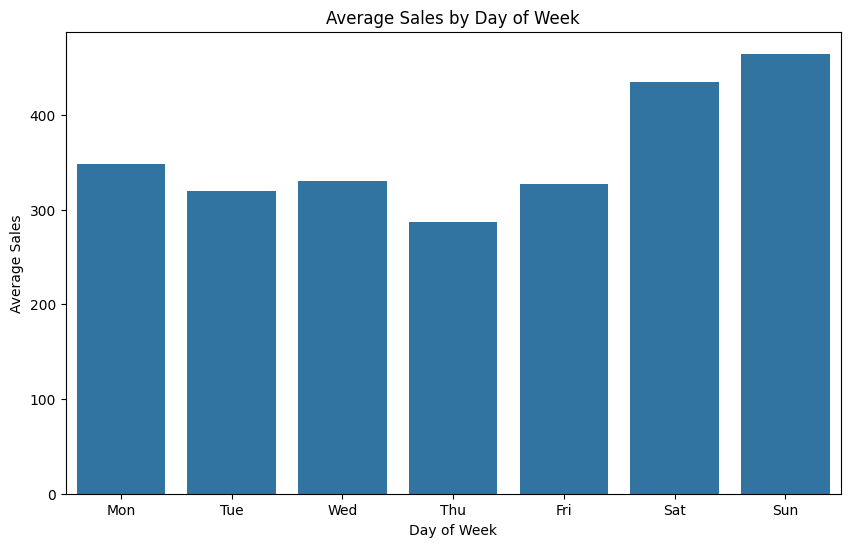

In [20]:
# Map numeric day values to day names for better readability
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
weekly_sales['day_name'] = weekly_sales['day_of_week'].map(day_map)

#visualize the weekly sales
plt.figure(figsize=(10, 6))
sns.barplot(data=weekly_sales, x='day_name', y='sales', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Sales")
plt.show()

In [21]:
# Monthly Seasonal Trends in sales.
monthly_sales = train.groupby('month')['sales'].mean().reset_index()

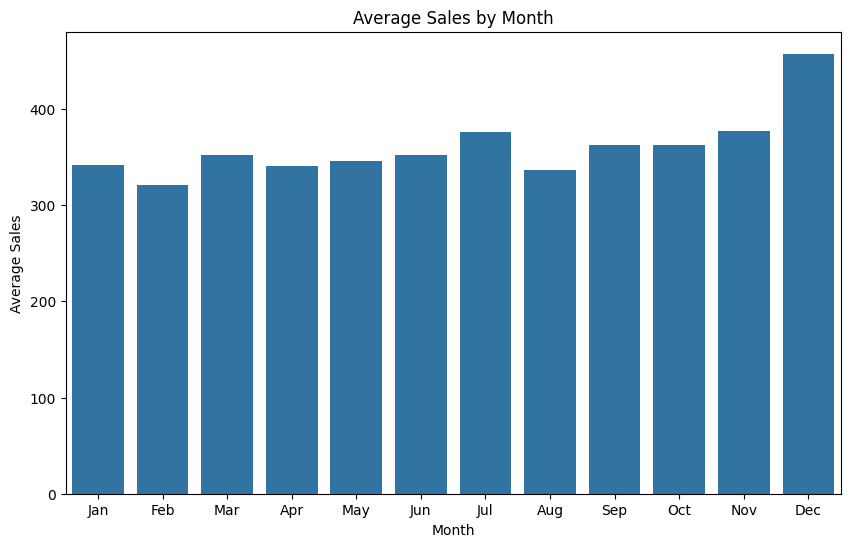

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_sales, x='month', y='sales', order=sorted(monthly_sales['month'].unique()))
plt.xticks(range(0, 12), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

### Event-based Features:

### Create binary flags for holidays, promotions, and economic events.

In [23]:
# check for column list in train data

train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale',
       'locale_name', 'description', 'transferred', 'day', 'week', 'month',
       'year', 'day_of_week'],
      dtype='object')

In [24]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

train.head()


id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x  cluster  dcoilwtico   type_y    locale locale_name  \
0      D       13       93.14  Holiday  National     Ecuador   
1      D       13       93.14  Holiday  National     Ecuador   
2      D       13       93.14  Holiday  National     Ecuador   
3      D       13       93.14  Holiday  National     Ecuador   
4      D       13       93.14  Holiday  National     Ecuador   

          description transferred  day  week  month  year  day_of_week  
0  Primer dia del ano       False    1     1      1  2013            1  
1  Primer dia del ano       False    1     1      1  2013            1  
2  Primer dia del ano       False    1     1      1  2013            1  
3  Primer dia del ano       False    1     1      1  2013            1  
4  Primer dia del ano       False    1     1      1  2013            1

In [25]:
# count unique vaue counts in "type_y" column.
unique_counts = train['type_y'].value_counts()
print(unique_counts)

type_y
Holiday       304722
Event          99792
Additional     67716
Transfer       16038
Work Day        8910
Bridge          5346
Name: count, dtype: int64


In [26]:
# Convert 'type_y' column to binary flag and remove the original column.
train['is_holiday'] = train['type_y'].notna().astype(int)
train.drop('type_y', axis=1, inplace=True)

In [28]:
# check for binary conversion in "is_holiday" column.
unique_counts = train['is_holiday'].value_counts()
print(unique_counts)

is_holiday
0    2551824
1     502524
Name: count, dtype: int64


In [29]:
# check the column values in "onpromotion" column.
promotion_counts = train['onpromotion'].value_counts()
print(promotion_counts)

onpromotion
0      2428528
1       178763
2        81141
3        46928
4        32453
5        25148
6        22579
7        19348
8        15924
9        14144
10       12824
11       11262
12        9855
13        8642
14        7398
15        6548
16        5982
17        5344
18        4942
19        4576
20        4477
21        4189
22        3763
23        3477
24        3284
25        2964
29        2930
27        2925
28        2910
30        2880
26        2845
31        2519
32        2317
35        2109
33        2102
34        2098
40        2049
36        2027
38        2021
37        1972
39        1966
43        1851
41        1822
42        1807
45        1782
47        1717
44        1702
46        1663
48        1615
49        1594
50        1504
51        1404
53        1394
52        1371
54        1226
55        1119
56        1064
57        1020
58         971
59         966
60         954
62         846
61         844
63         791
64         779
65         74

In [30]:
# convert "onpromotion" column to binary flag as is.
train['onpromotion'] = (train['onpromotion'] != 0).astype(int)

In [31]:
# check whether the conversion is done or not.
promotion_counts = train['onpromotion'].value_counts()
print(promotion_counts)

onpromotion
0    2428528
1     625820
Name: count, dtype: int64


In [32]:
# economic events in this situation other than holidays and weekends and promotions  are oil prices which is already covered as a feature.
# change the column name of oil prices from "dcoilwtico" to "daily_oil_price".capitalize
train.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
print(train.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'oil_price', 'locale', 'locale_name',
       'description', 'transferred', 'day', 'week', 'month', 'year',
       'day_of_week', 'is_holiday'],
      dtype='object')


### Identify if a day is a government payday (15th and last day of the month).

In [33]:
# government payday is given as 15th and last day of the month.
train['is_gov_payday'] = train.apply(lambda row: int(row['day'] in [15, row['date'].days_in_month]), axis=1)

In [34]:
# check the value counts in the 'is_gov_payday' column.
gov_payday_counts = train['is_gov_payday'].value_counts()
print(gov_payday_counts)

is_gov_payday
0    2856546
1     197802
Name: count, dtype: int64


### Consider earthquake impact (April 16, 2016) as a separate feature.

In [35]:
# given that earthquake impact date is 16th April 2016, we can create a new feature to indicate if the date is before or after the earthquake.
train['earthquake_impact'] = (train['date'] == '2016-04-16').astype(int)

In [36]:
# check for the binary in the 'earthquake_impact' column.
Earthquake_counts = train['earthquake_impact'].value_counts()
print(Earthquake_counts)

earthquake_impact
0    3052566
1       1782
Name: count, dtype: int64


In [39]:
# check the average sales after outlier treatment.

Q1 = train['sales'].quantile(0.25)
Q3 = train['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_train = train[(train['sales'] >= lower_bound) & (train['sales'] <= upper_bound)]
daily_sales = filtered_train.groupby('date').agg({'sales': 'mean', 'earthquake_impact': 'max'}).reset_index()

# compare dat to day average sales vs earthquake day sales
daily_avg_sales = daily_sales['sales'].mean()
earthquake_avg_sales = daily_sales.loc[daily_sales['earthquake_impact'] == 1, 'sales'].mean()

print("Overall Daily Average Sales:", daily_avg_sales )
print("Earthquake Day Average Sales:", earthquake_avg_sales )

Overall Daily Average Sales: 59.229119684320025
Earthquake Day Average Sales: 74.02151970778773


### as weekends have considerable impact on sales convert it into a feature.

In [40]:
# to convert into weekends we need day of the week column and use it to create a seperate feature.
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)

In [41]:
# check the binary values in the 'is_weekend' column.
weekend_counts = train['is_weekend'].value_counts()
print(weekend_counts)

is_weekend
0    2175822
1     878526
Name: count, dtype: int64


In [42]:
# check the dataframe columns after adding new features.
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'oil_price', 'locale', 'locale_name',
       'description', 'transferred', 'day', 'week', 'month', 'year',
       'day_of_week', 'is_holiday', 'is_gov_payday', 'earthquake_impact',
       'is_weekend'],
      dtype='object')

### check the data frame "train" for date consistency, missing dates, and other required imputations, if any.

In [43]:
# check dtypes of the columns in the train data set.
train.dtypes

id                            int64
date                 datetime64[ns]
store_nbr                     int64
family                       object
sales                       float64
onpromotion                   int64
city                         object
state                        object
type_x                       object
cluster                       int64
oil_price                   float64
locale                       object
locale_name                  object
description                  object
transferred                  object
day                           int32
week                         UInt32
month                         int32
year                          int32
day_of_week                   int32
is_holiday                    int64
is_gov_payday                 int64
earthquake_impact             int64
is_weekend                    int64
dtype: object

In [44]:
# check the the categorical or objective columns for unique values. it will help in encoding or dropping unnecessary columns.
family_counts = train['family'].value_counts()
city_counts = train['city'].value_counts()
state_counts = train['state'].value_counts()
store_type_counts = train['type_x'].value_counts()
locale_counts = train['locale'].value_counts()
locale_name_counts = train['locale_name'].value_counts()
transferred_counts = train['transferred'].value_counts()
description_counts = train['description'].value_counts()

print(family_counts)
print("-" * 40)
print(city_counts)
print("-" * 40)
print(state_counts)
print("-" * 40)
print(store_type_counts)
print("-" * 40)
print(locale_counts)
print("-" * 40)
print(locale_name_counts)
print("-" * 40)
print(transferred_counts)
print("-" * 40)
print(description_counts)

family
AUTOMOTIVE                    92556
BABY CARE                     92556
BEAUTY                        92556
BEVERAGES                     92556
BOOKS                         92556
BREAD/BAKERY                  92556
CELEBRATION                   92556
CLEANING                      92556
DAIRY                         92556
DELI                          92556
EGGS                          92556
FROZEN FOODS                  92556
GROCERY I                     92556
GROCERY II                    92556
HARDWARE                      92556
HOME AND KITCHEN I            92556
HOME AND KITCHEN II           92556
HOME APPLIANCES               92556
HOME CARE                     92556
LADIESWEAR                    92556
LAWN AND GARDEN               92556
LINGERIE                      92556
LIQUOR,WINE,BEER              92556
MAGAZINES                     92556
MEATS                         92556
PERSONAL CARE                 92556
PET SUPPLIES                  92556
PLAYERS AND ELECTRONI

In [45]:
# from the main data set "train.csv" we have understood that it is a grouped data on the basis of store_nbr and family.
# from the above unique value counts we can drop "description" column as it is not useful for the model.
# we can also drop "locale" and "locale_name" columns as they are redundant too.
# transfered column is also not useful for the model.(ambiguous)
# we can also drop "city" and "state" columns as they are not much useful. 
# we can do feature selection accordingly.

In [46]:
# drop the description column from the train data set.
train.drop('description', axis=1, inplace=True)

### Rolling Statistics:

### Compute moving averages and rolling standard deviations for past sales.

In [47]:
# smooth the sales data by using rolling statistics over a 7-day window.
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).mean().reset_index(level = [0, 1], drop=True)
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).std().reset_index(level = [0,1], drop=True)

### Include lagged features (e.g., sales from the previous week, previous month).

In [49]:
# include lagged features for a month and a week. Usually applied to capture the seasonality in the data.
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['sales_lag_30'] = train.groupby(['store_nbr', 'family'])['sales'].shift(30)

### Store-Specific Aggregations:

### Compute average sales per store type.

In [50]:
# now calculate store based average sales then merge the column with the train data frame.
store_avg_sales = train.groupby('store_nbr')['sales'].mean().rename('avg_store_sales')
train = train.merge(store_avg_sales, on = 'store_nbr', how = 'left')

### Identify top-selling product families per cluster.

In [51]:
# Compute total sales per cluster and family
cluster_family_sales = train.groupby(['cluster', 'family'])['sales'].sum().reset_index()

# Sort by cluster and descending sales
cluster_family_sales = cluster_family_sales.sort_values(['cluster', 'sales'], ascending=[True, False])

# For each cluster, select the top 5 families
top5_families = cluster_family_sales.groupby('cluster').head(5)

# Filter the original data to include only rows corresponding to these top 5 families per cluster
top5_data = pd.merge(train, top5_families[['cluster', 'family']], on=['cluster', 'family'], how='inner')

# Compute the daily average sales for each cluster and product family
daily_avg_sales = top5_data.groupby(['cluster', 'family', 'date'])['sales'].mean().reset_index()

# Apply a 7-day moving average on the daily average sales for each group. The rolling function computes the moving average over a window of 7 days.
daily_avg_sales['rolling_avg'] = daily_avg_sales.groupby(['cluster', 'family'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())




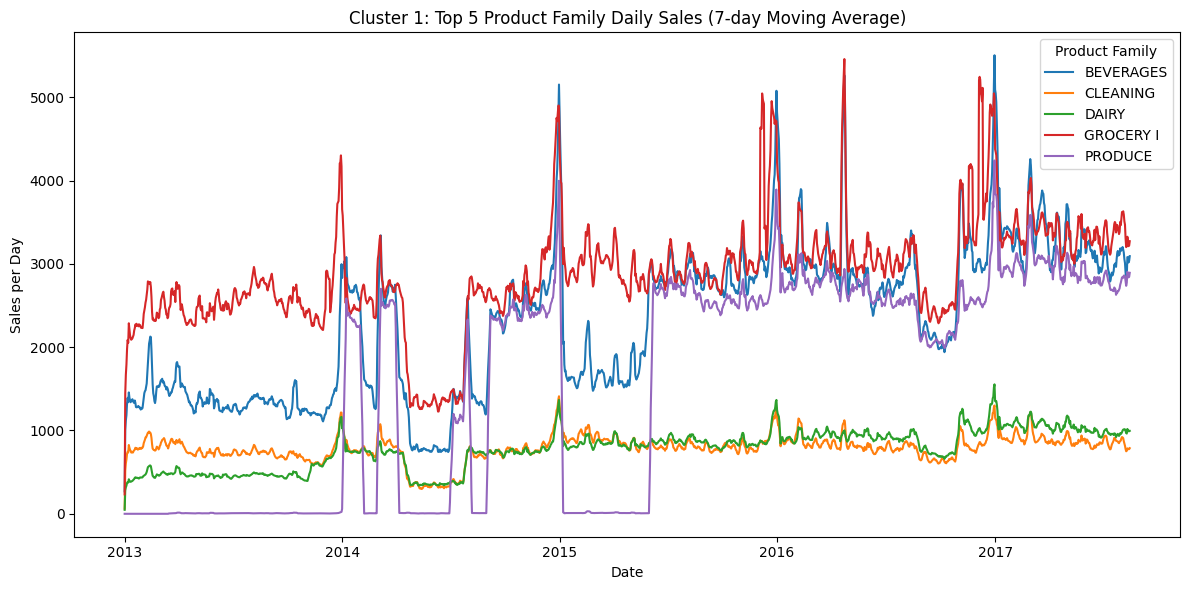

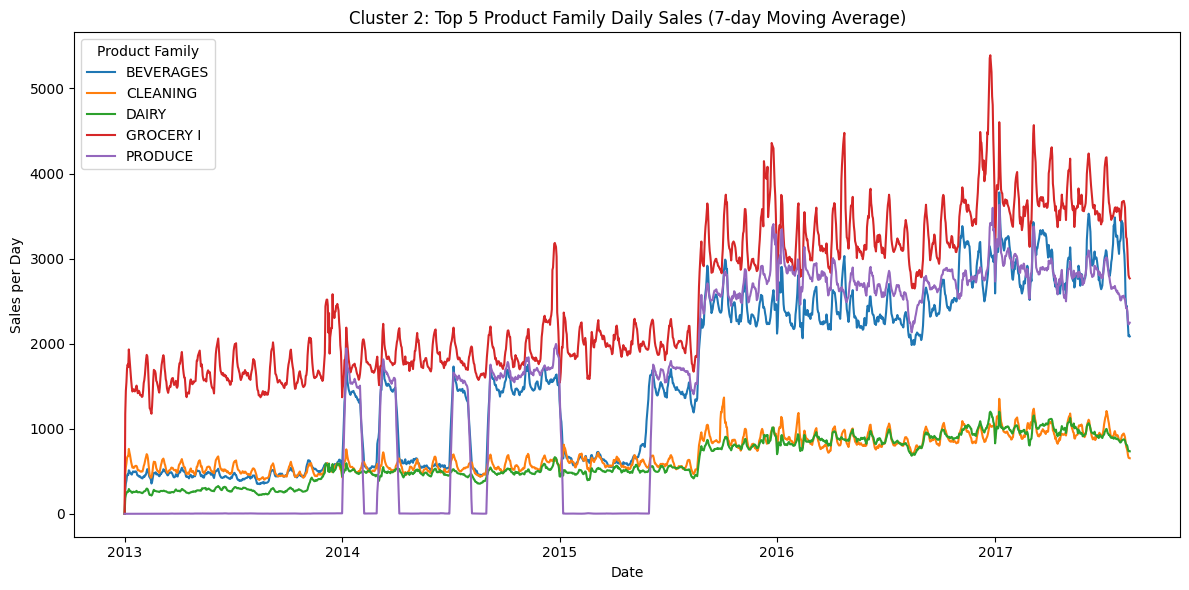

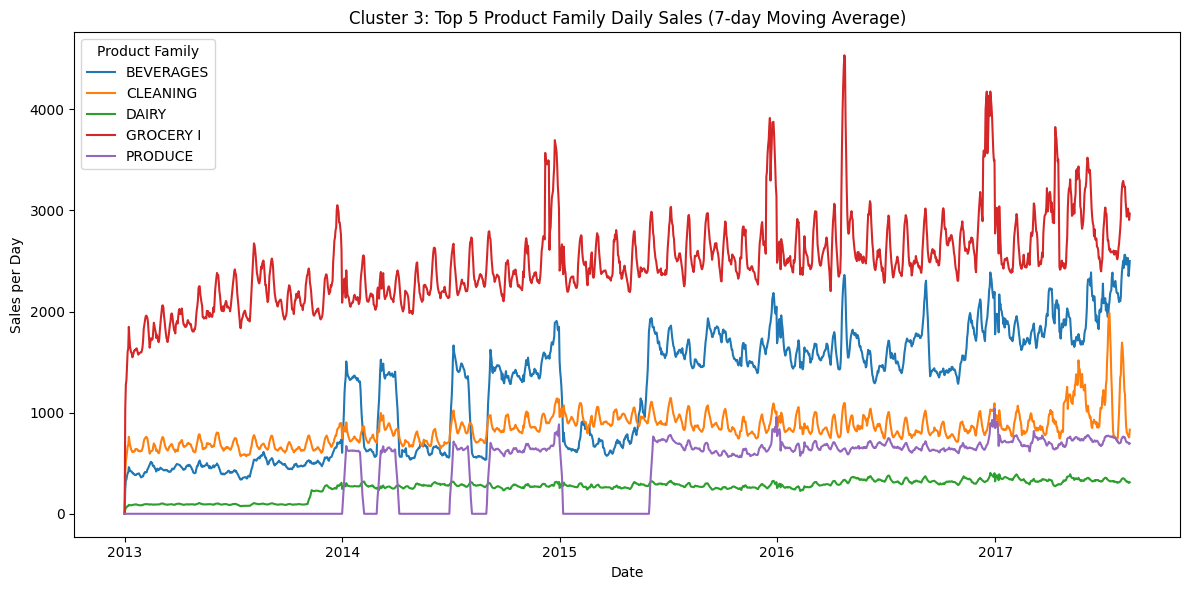

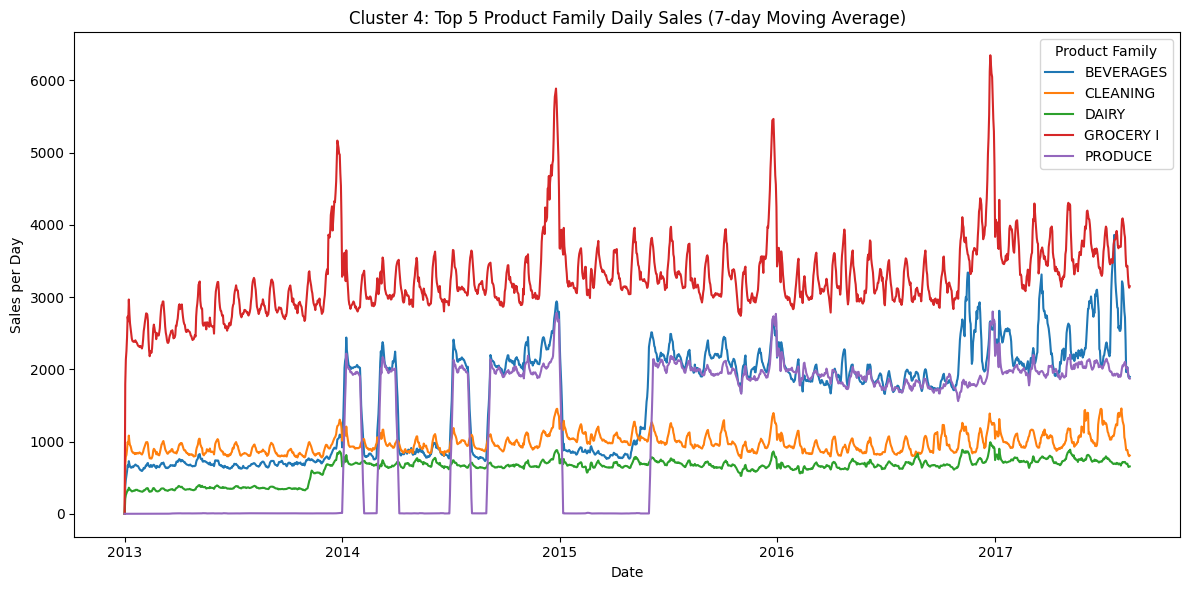

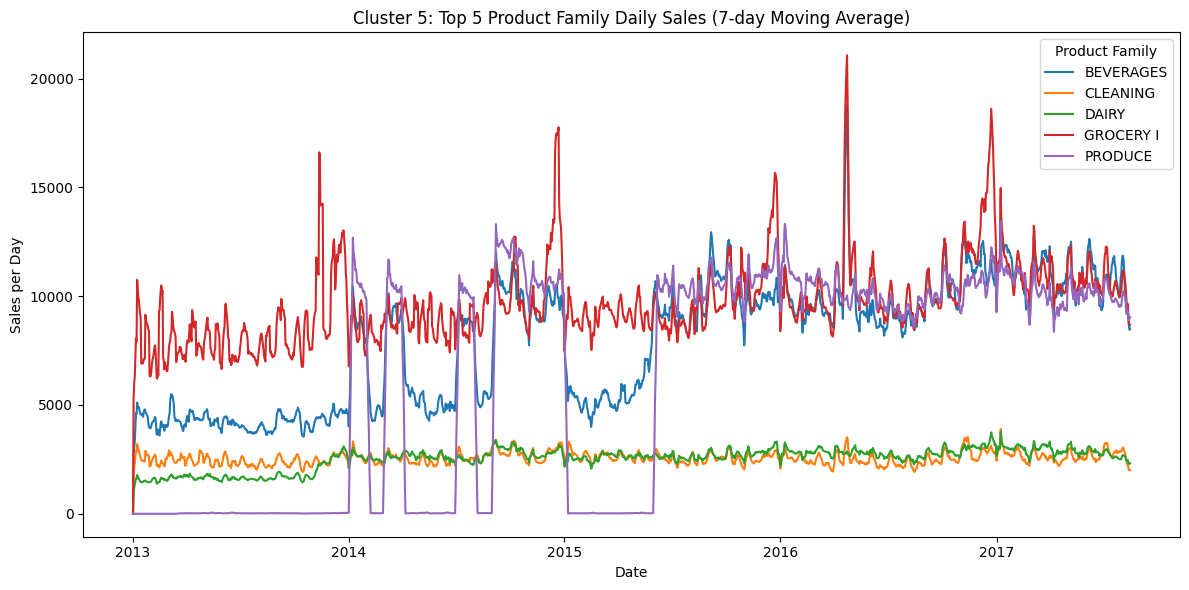

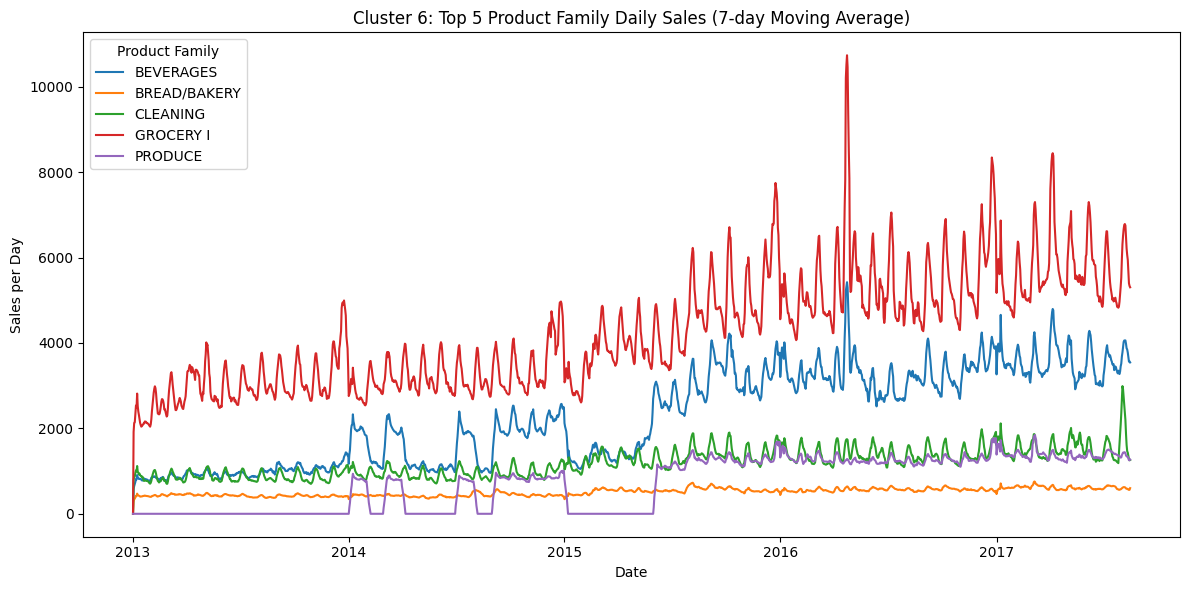

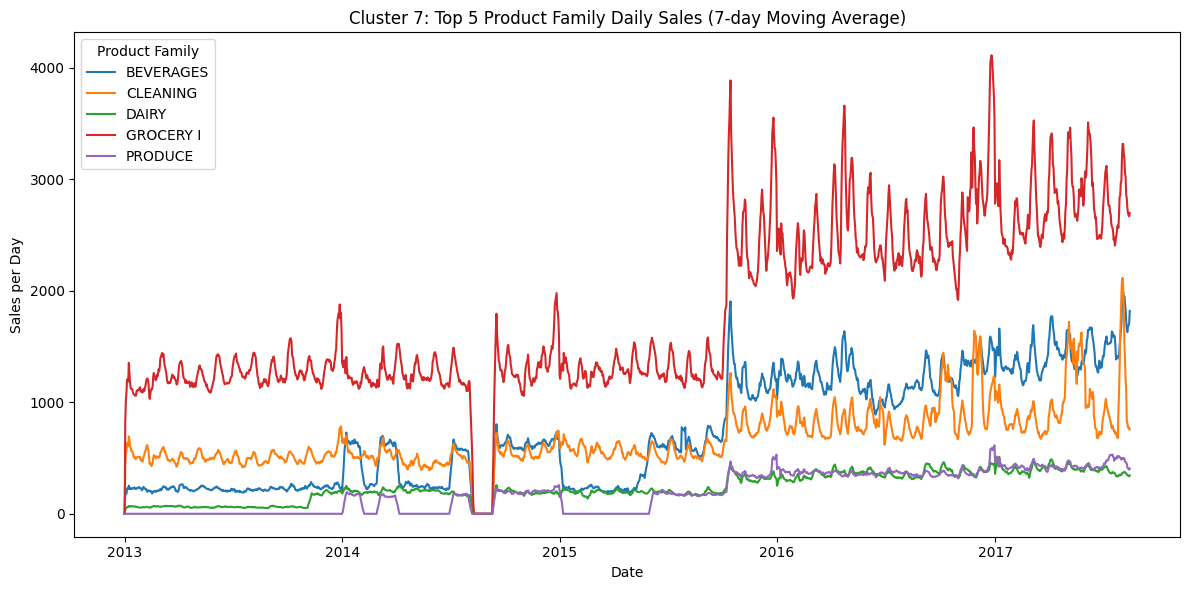

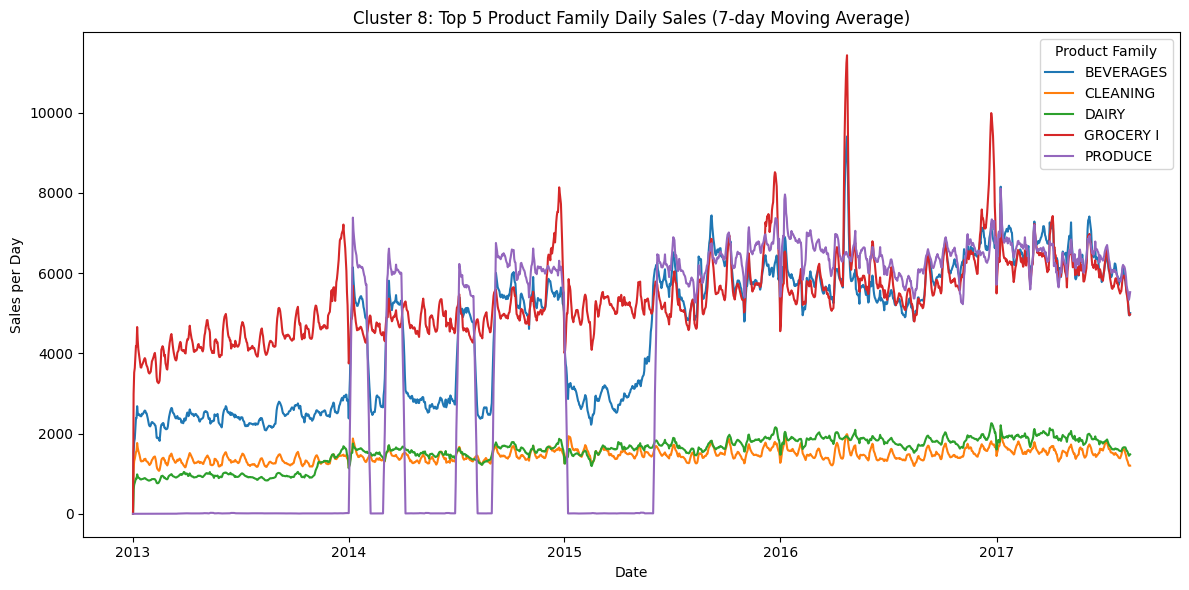

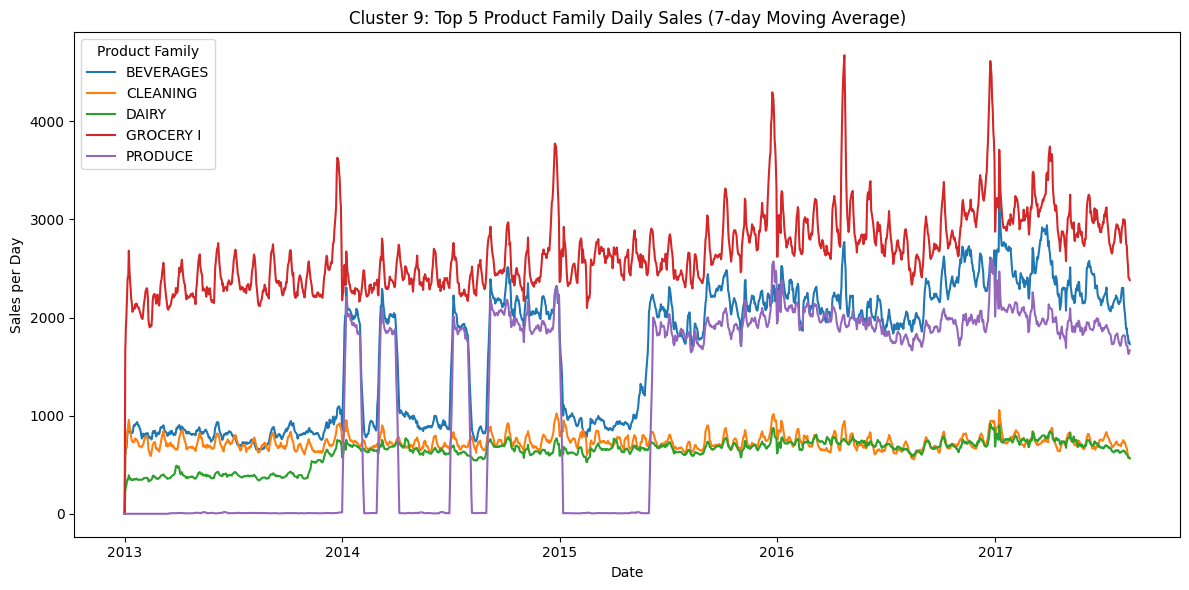

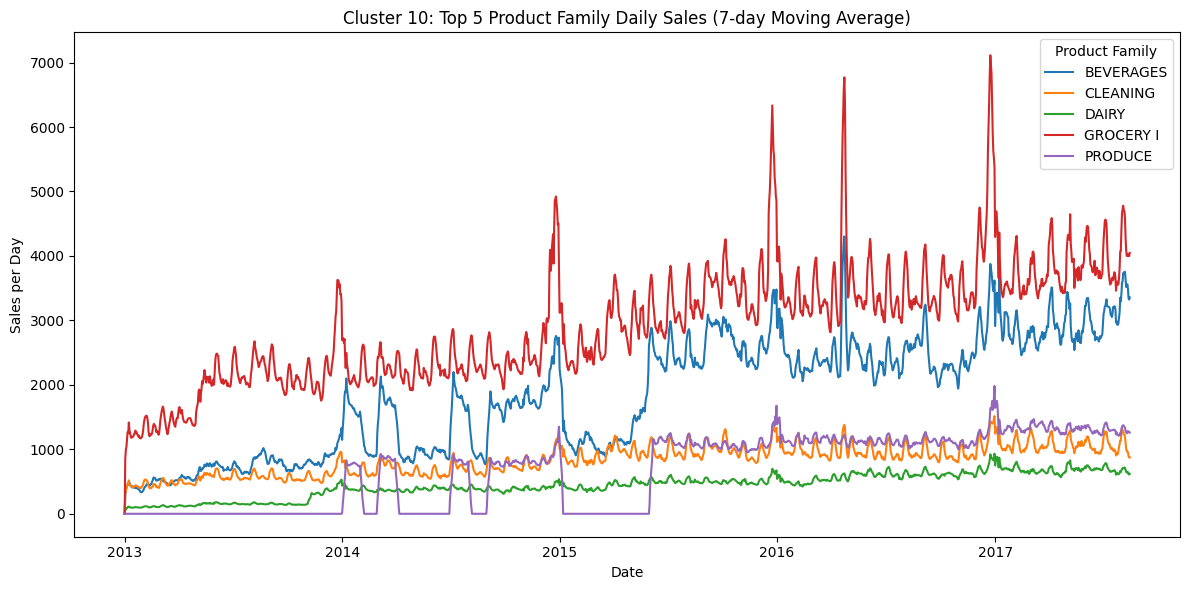

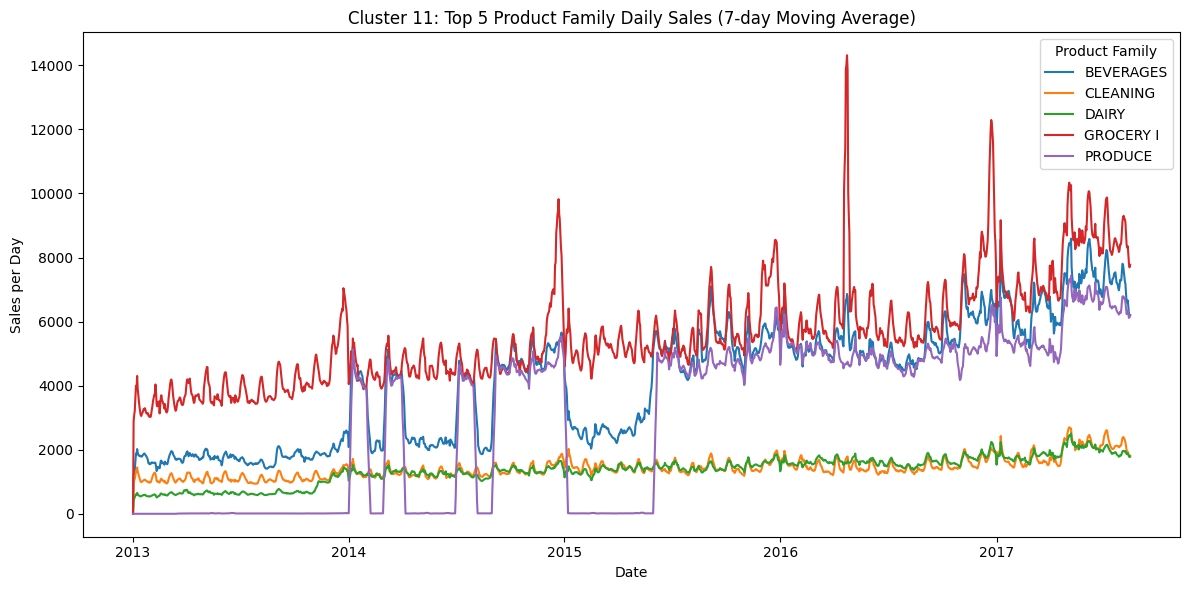

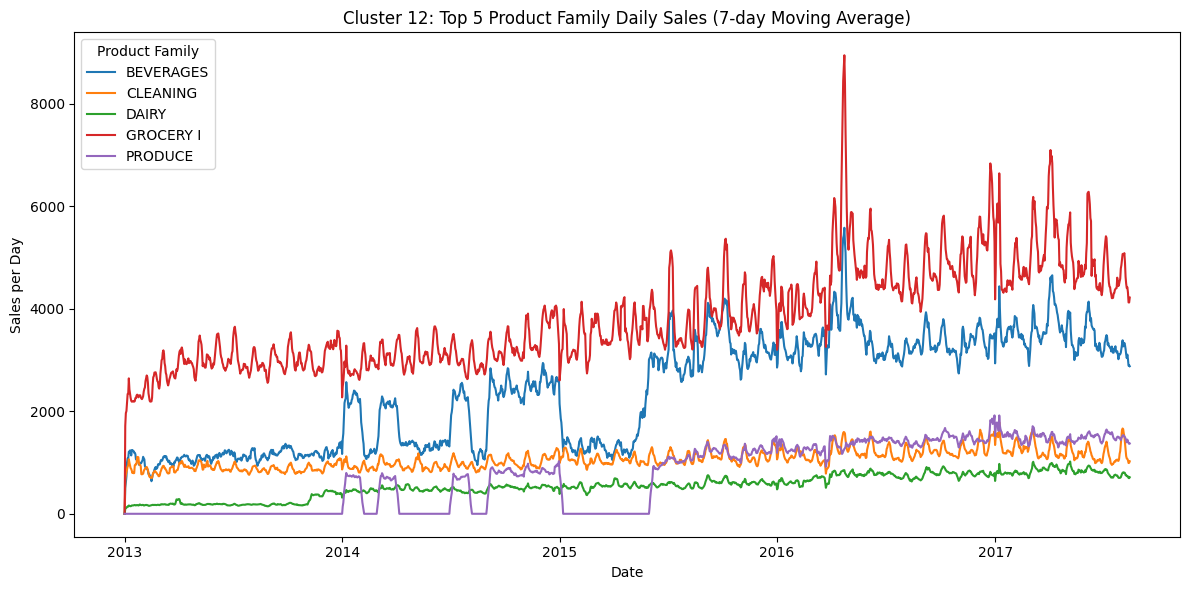

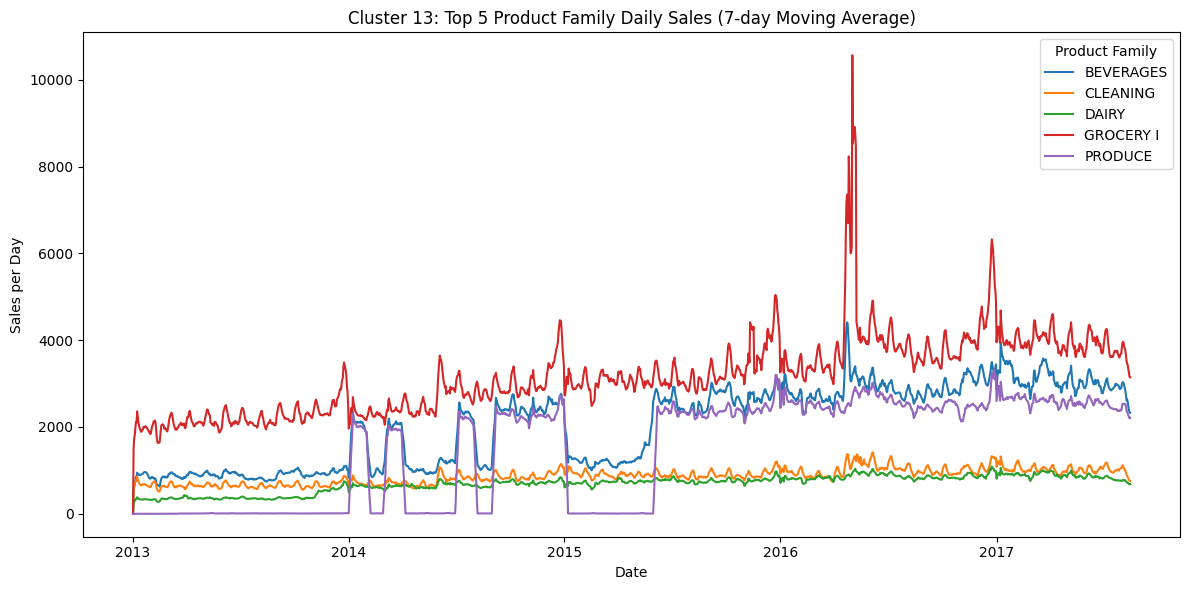

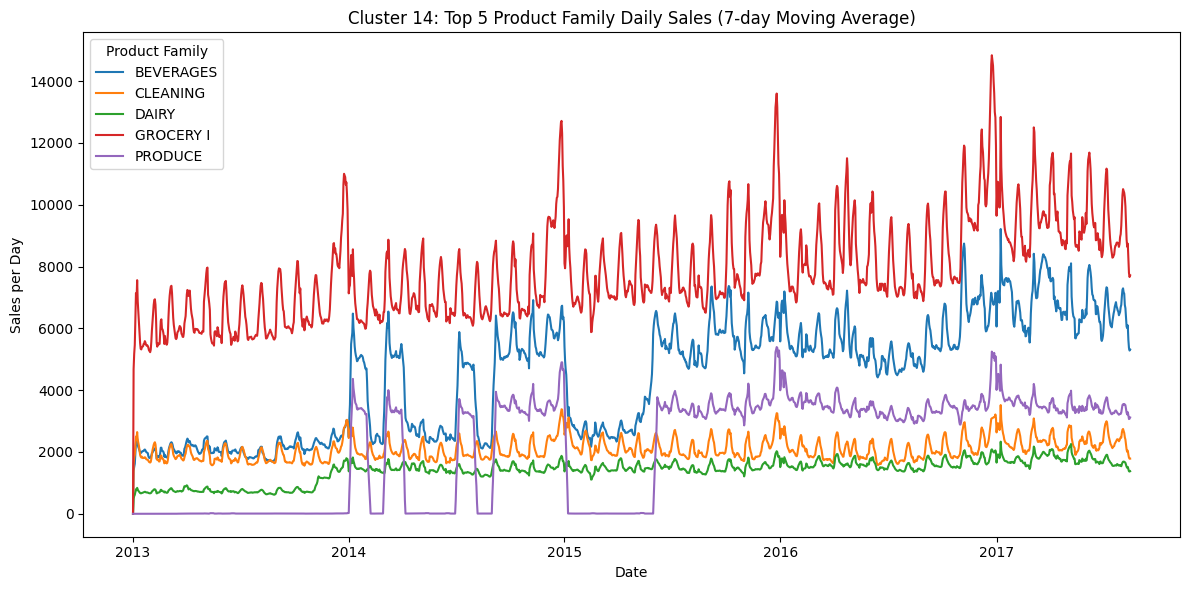

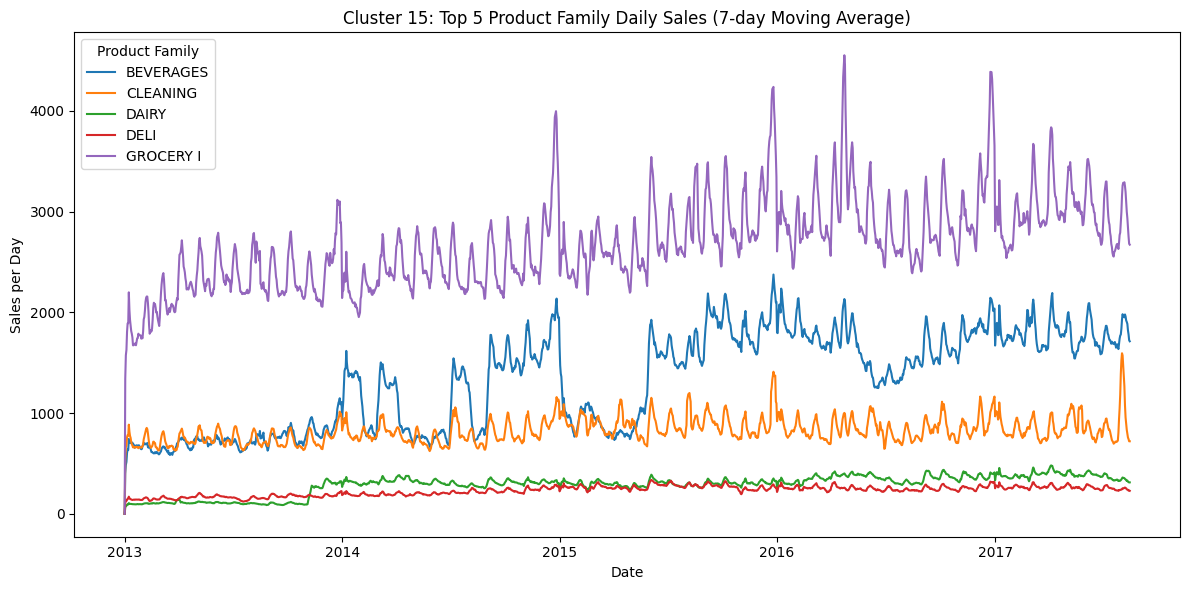

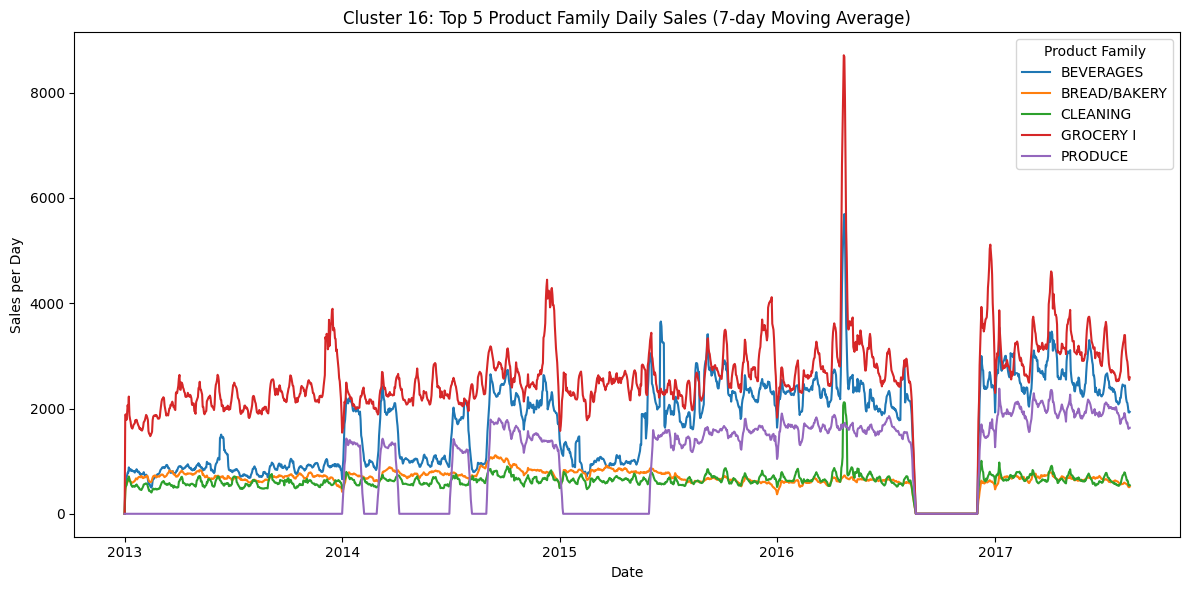

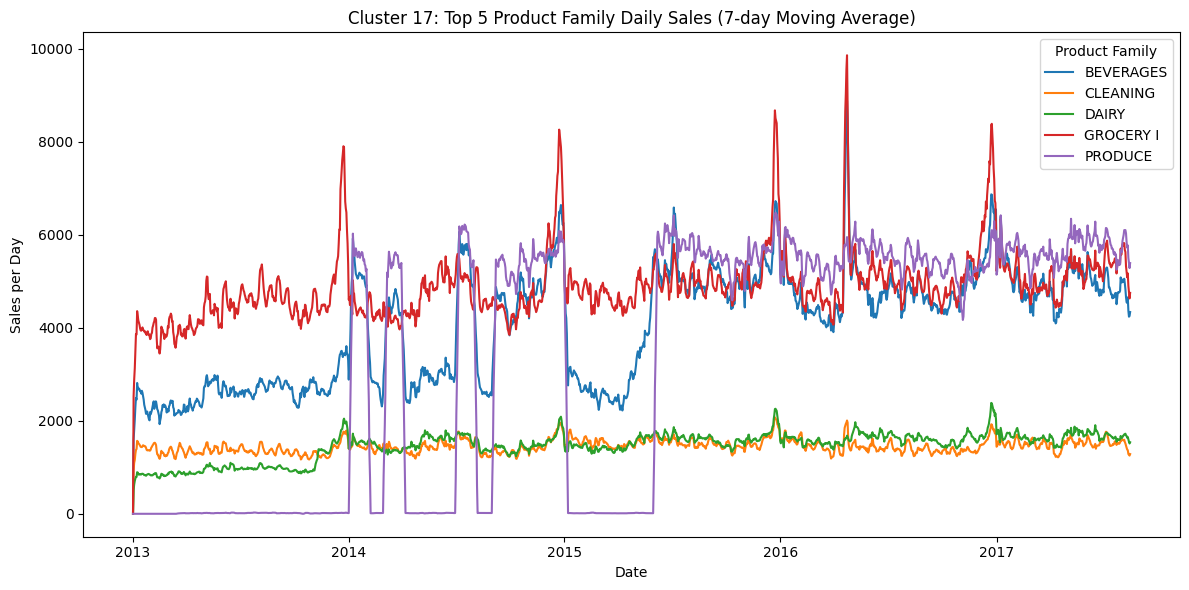

In [168]:
# Plot the 7-day moving average of daily average sales for the top 5 families, for each cluster
clusters = daily_avg_sales['cluster'].unique()

for x in clusters:
    plt.figure(figsize=(12, 6))
    # For each top family in the current cluster, plot its rolling average sales
    for y in daily_avg_sales[daily_avg_sales['cluster'] == x]['family'].unique():
        subset = daily_avg_sales[(daily_avg_sales['cluster'] == x) & (daily_avg_sales['family'] == y)]
        plt.plot(subset['date'], subset['rolling_avg'], label=f'{y}')
    
    plt.title(f'Cluster {x}: Top 5 Product Family Daily Sales (7-day Moving Average)')
    plt.xlabel('Date')
    plt.ylabel('Sales per Day')
    plt.legend(title='Product Family')
    plt.tight_layout()
    plt.show()

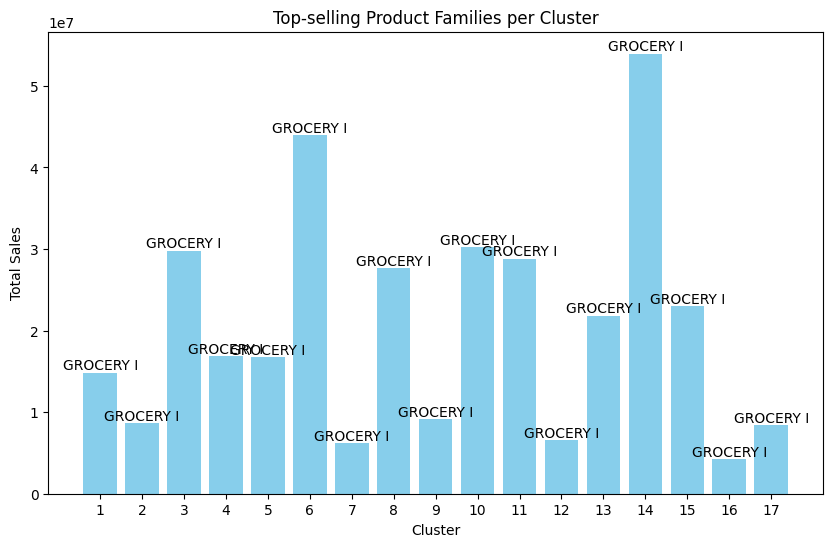

In [52]:
# visualisation of the top product families per cluster.
top_families = cluster_family_sales.groupby('cluster').head(1)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_families['cluster'].astype(str), top_families['sales'], color='skyblue')
plt.title('Top-selling Product Families per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')

for bar, fam in zip(bars, top_families['family']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), fam,
             ha='center', va='bottom', fontsize=10)

plt.show()

## 3. Exploratory Data Analysis (EDA)

### Visualize sales trends over time.

EDA


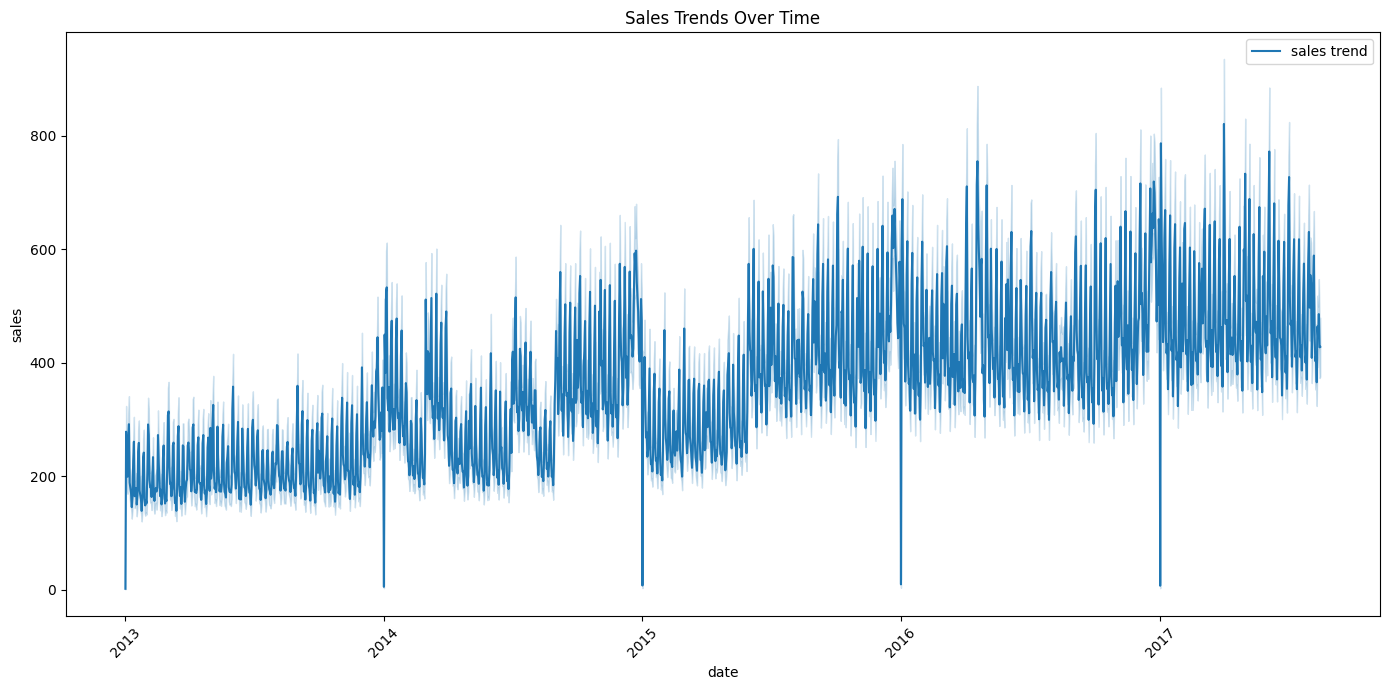

In [53]:
# visualing sales trends over time.
print("EDA")
plt.figure(figsize = (14, 7))
sns.lineplot(x ='date', y = 'sales', data = train, label = 'sales trend' )
plt.title('Sales Trends Over Time')
plt.xlabel('date')
plt.ylabel('sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

### Analyze sales before and after holidays and promotions.

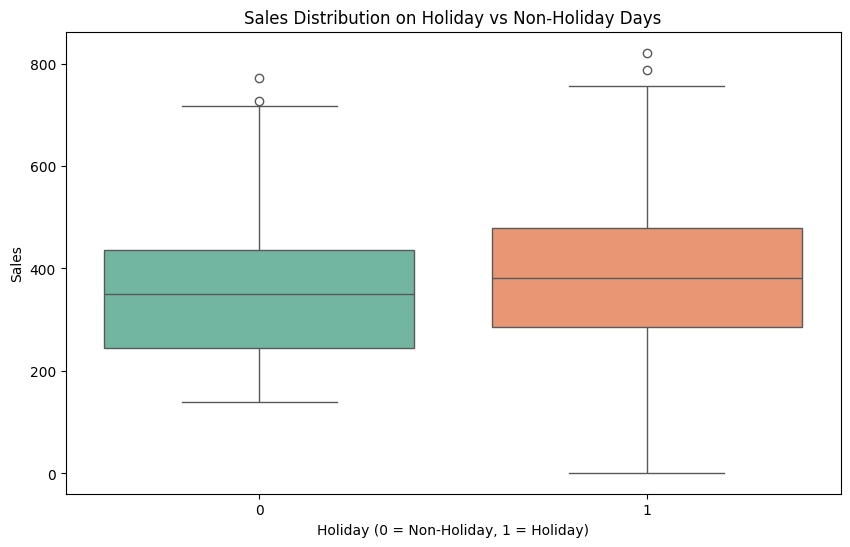

In [54]:
holiday_sales = train.groupby(['date', 'is_holiday'])['sales'].mean().reset_index()
# Visualize sales distribution by holiday status using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="is_holiday", y="sales", data=holiday_sales, palette="Set2")
plt.title("Sales Distribution on Holiday vs Non-Holiday Days")
plt.xlabel("Holiday (0 = Non-Holiday, 1 = Holiday)")
plt.ylabel("Sales")
plt.show()

### Check correlations between oil prices and sales trends.


Correlation between oil prices and sales: -0.08


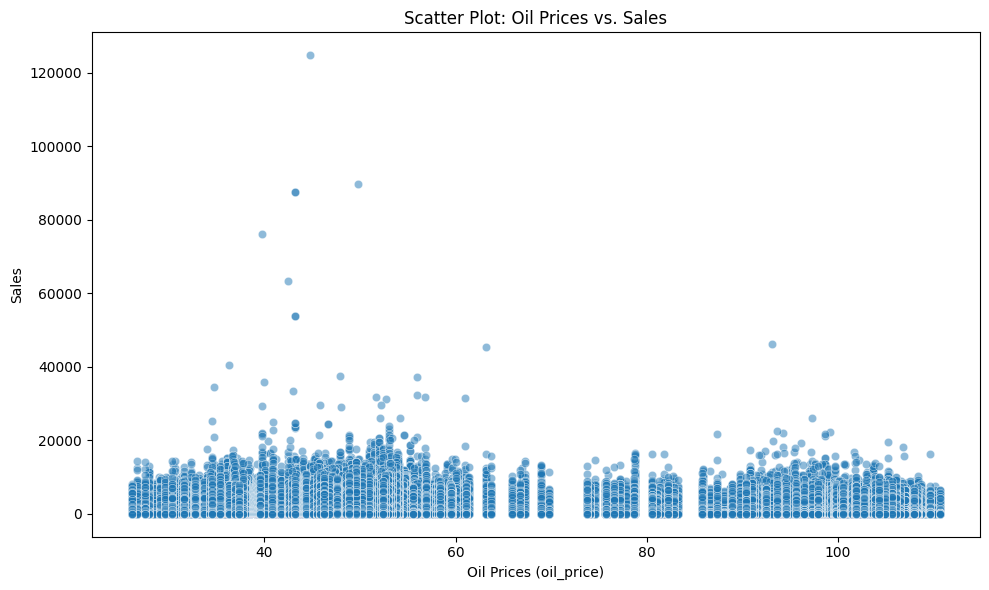

In [55]:
# Calculate the correlation coefficient between oil prices and sales
corr_value = train[['oil_price', 'sales']].corr().iloc[0, 1]
print(f"Correlation between oil prices and sales: {corr_value:.2f}")

# Visualize the relationship using a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='oil_price', y='sales', data=train, alpha=0.5)
plt.title("Scatter Plot: Oil Prices vs. Sales")
plt.xlabel("Oil Prices (oil_price)")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

### Findings:

In [56]:
# Oil prices are having a neglagible correlation with sales. which indicates that oil prices are not a good predictor for sales.
# Holidays vs non-holiday sales suggesting that sales are higher on holidays than non-holidays.
# sales trend over time is increasing.
# sales are higher on weekends than weekdays.
# Grocery 1 is the top selling product family in all clusters.
# Common top selling product families across all clusters are Grocery 1, cleaning, produce, and Beverages.
# earth quake impact on sales is significant, as the average sales on the day of the earthquake is higher than the overall average sales.

### identify anamolies in the data set.

In [59]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the sales column
Q1 = train['sales'].quantile(0.25)
Q3 = train['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

# Identify anomalies in sales data (both low and high outliers)
anomalies = train[(train['sales'] < lower_bound) | (train['sales'] > upper_bound)]

print("Number of anomalies in sales:", anomalies.shape[0])

Lower bound: -294.02, Upper bound: 490.03
Number of anomalies in sales: 455506


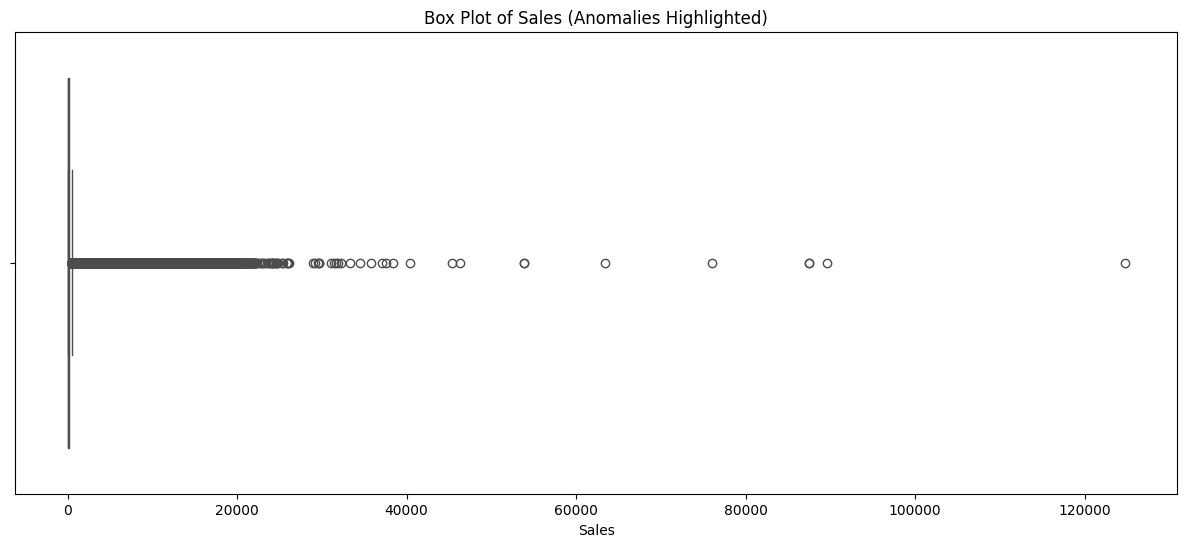

In [60]:
# Visualize the sales distribution with a box plot to highlight anomalies
plt.figure(figsize=(15, 6))
sns.boxplot(x=train['sales'], color='red')
plt.title("Box Plot of Sales (Anomalies Highlighted)")
plt.xlabel("Sales")
plt.show()

### final Data frame consistency check with binary features and other engineered features.

In [61]:
# check train data featured columns
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'oil_price', 'locale', 'locale_name',
       'transferred', 'day', 'week', 'month', 'year', 'day_of_week',
       'is_holiday', 'is_gov_payday', 'earthquake_impact', 'is_weekend',
       'rolling_mean_7', 'rolling_std_7', 'sales_lag_7', 'sales_lag_30',
       'avg_store_sales'],
      dtype='object')

In [62]:
# train data data types of columns.
train.dtypes

id                            int64
date                 datetime64[ns]
store_nbr                     int64
family                       object
sales                       float64
onpromotion                   int64
city                         object
state                        object
type_x                       object
cluster                       int64
oil_price                   float64
locale                       object
locale_name                  object
transferred                  object
day                           int32
week                         UInt32
month                         int32
year                          int32
day_of_week                   int32
is_holiday                    int64
is_gov_payday                 int64
earthquake_impact             int64
is_weekend                    int64
rolling_mean_7              float64
rolling_std_7               float64
sales_lag_7                 float64
sales_lag_30                float64
avg_store_sales             

In [63]:
# randomly selecting 20 rows from the train dataset to check dataframe.
train.sample(20)

id       date  store_nbr                      family     sales  \
2882275  2834161 2017-05-14         30            LIQUOR,WINE,BEER    97.000   
774547    765637 2014-03-07         41                       BOOKS     0.000   
2164047  2137317 2016-04-17         29                 CELEBRATION     7.000   
2780314  2733982 2017-03-19          2  SCHOOL AND OFFICE SUPPLIES     0.000   
407681    400553 2013-08-13         47                     SEAFOOD    46.911   
838996    830086 2014-04-12          5                       BOOKS     0.000   
986481    972225 2014-07-01         38                   GROCERY I  4086.000   
1764063  1739115 2015-09-05          6          HOME AND KITCHEN I    26.000   
2074354  2047624 2016-02-27         12                    CLEANING  1539.000   
2567994  2523444 2016-11-20         13                  AUTOMOTIVE     6.000   
448109    440981 2013-09-05         32                      BEAUTY     0.000   
2409090  2366322 2016-08-23         53                       MEATS   232.873   
811759    802849 2014-03-28         35               PERSONAL CARE    77.000   
2768413  2722081 2017-03-12         36                        EGGS   107.000   
757193    748283 2014-02-25         54                       DAIRY   158.000   
2713086  2666754 2017-02-09         33                       MEATS   437.042   
1520315  1500713 2015-04-25         17                BREAD/BAKERY   196.000   
2468359  2425591 2016-09-26         17               PERSONAL CARE   219.000   
2698161  2651829 2017-02-01         15          HOME AND KITCHEN I    84.000   
2070504  2043774 2016-02-24         53                   HOME CARE   130.000   

         onpromotion           city                           state type_x  \
2882275            1      Guayaquil                          Guayas      C   
774547             0        Machala                          El Oro      D   
2164047            0      Guayaquil                          Guayas      E   
2780314            0          Quito                       Pichincha      D   
407681             0          Quito                       Pichincha      A   
838996             0  Santo Domingo  Santo Domingo de los Tsachilas      D   
986481             1           Loja                            Loja      D   
1764063            0          Quito                       Pichincha      D   
2074354            1      Latacunga                        Cotopaxi      C   
2567994            0      Latacunga                        Cotopaxi      C   
448109             0      Guayaquil                          Guayas      C   
2409090            0          Manta                          Manabi      D   
811759             0         Playas                          Guayas      C   
2768413            1       Libertad                          Guayas      E   
757193             0      El Carmen                          Manabi      C   
2713086            1        Quevedo                        Los Rios      C   
1520315            0          Quito                       Pichincha      C   
2468359            1          Quito                       Pichincha      C   
2698161            1         Ibarra                        Imbabura      C   
2070504            0          Manta                          Manabi      D   

         cluster  oil_price    locale locale_name transferred  day  week  \
2882275        3        NaN  National     Ecuador       False   14    19   
774547         4     102.82       NaN         NaN         NaN    7    10   
2164047       10        NaN  National     Ecuador       False   17    15   
2780314       13        NaN       NaN         NaN         NaN   19    11   
407681        14     106.78       NaN         NaN         NaN   13    33   
838996         4        NaN     Local      Cuenca       False   12    15   
986481         4     106.06  National     Ecuador       False    1    27   
1764063       13        NaN       NaN         NaN         NaN    5    36   
2074354   

In [64]:
# export the dataset to a new csv fileto save progress for another day.
train.to_csv("processed_train.csv", index=False)

## Part 2: Model Selection, Forecasting, and Evaluation (Day 2)

### Data Preparation

In [65]:
# import the processed train dataset.
train = pd.read_csv("processed_train.csv", parse_dates=['date'], low_memory=False)

In [66]:
# preparing training data for the future models.
features = ['day', 'week', 'month', 'year', 'day_of_week','onpromotion',
       'is_holiday', 'is_gov_payday', 'earthquake_impact', 'is_weekend',
       'rolling_mean_7', 'rolling_std_7', 'sales_lag_7', 'sales_lag_30',
       'avg_store_sales']
X = train[features].dropna()
y = train.loc[X.index, 'sales']

In [67]:
# split into train and test validation sets
train_size = int(len(X)*0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [68]:
# Sample 10,000 data points for faster training
y_train_sample = y_train.iloc[-10000:] 

### 1. Model Training

### Baseline Model (Naïve Forecasting) - Assume future sales = previous sales.

In [69]:
# Naive forecasting or base model here we have to assume future sales = previous sales
train['naive_forecast'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)

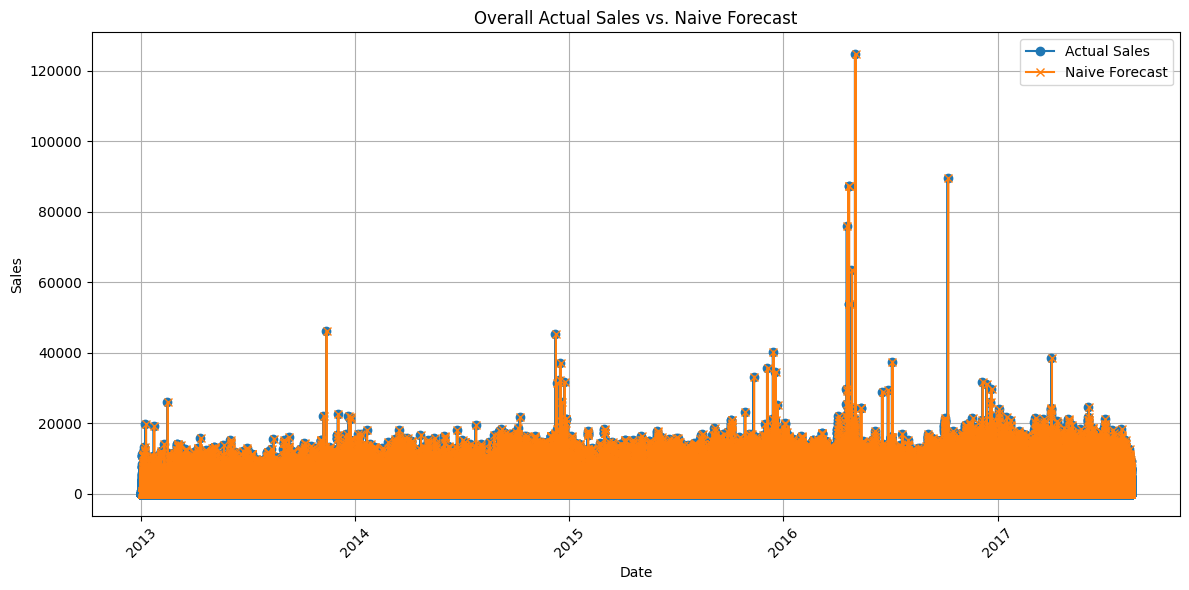

In [70]:
# Visualise Naive forecasting.
plt.figure(figsize=(12,6))
plt.plot(train['date'], train['sales'], label='Actual Sales', marker='o')
plt.plot(train['date'], train['naive_forecast'], label='Naive Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Overall Actual Sales vs. Naive Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### ARIMA Model.

In [72]:
# Construct an ARIMA model for sales forecasting.
# Define the ARIMA model
arima_model = ARIMA(y_train_sample, order=(5, 1, 0))
arima_model_fit = arima_model.fit(low_memory=True)
arima_preds = arima_model_fit.forecast(steps = len(y_val))

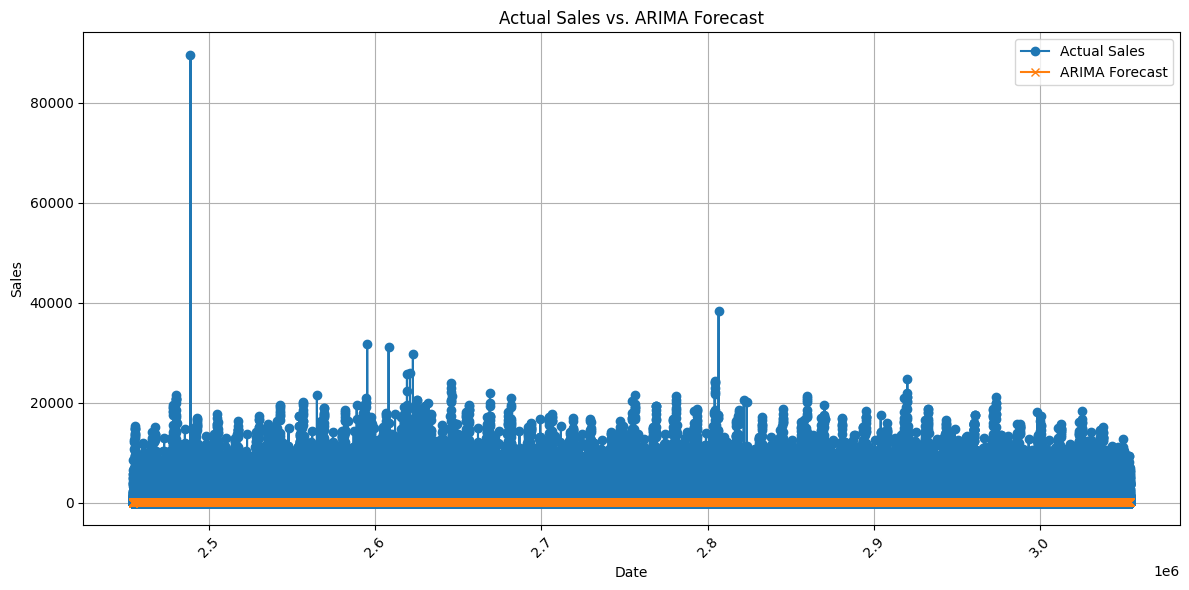

In [73]:
# Generate a fore casting visualisation for above model.
plt.figure(figsize=(12,6))
plt.plot(y_val.index, y_val, label='Actual Sales', marker='o')
plt.plot(y_val.index, arima_preds, label='ARIMA Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual Sales vs. ARIMA Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Random Forest Regressor Model.

In [74]:
# Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs= -1, bootstrap=False, random_state=42)
X_sample, y_sample = X_train.sample(50000, random_state=42), y_train.loc[X_train.sample(50000, random_state =42).index]
rf_model.fit(X_sample, y_sample)
rf_preds = rf_model.predict(X_val)

In [75]:
# Fit the model.
rf_model.fit(X_sample, y_sample)

RandomForestRegressor(bootstrap=False, max_depth=10, n_estimators=50, n_jobs=-1,
                      random_state=42)

In [76]:
# Predict the sales.
rf_preds = rf_model.predict(X_val)

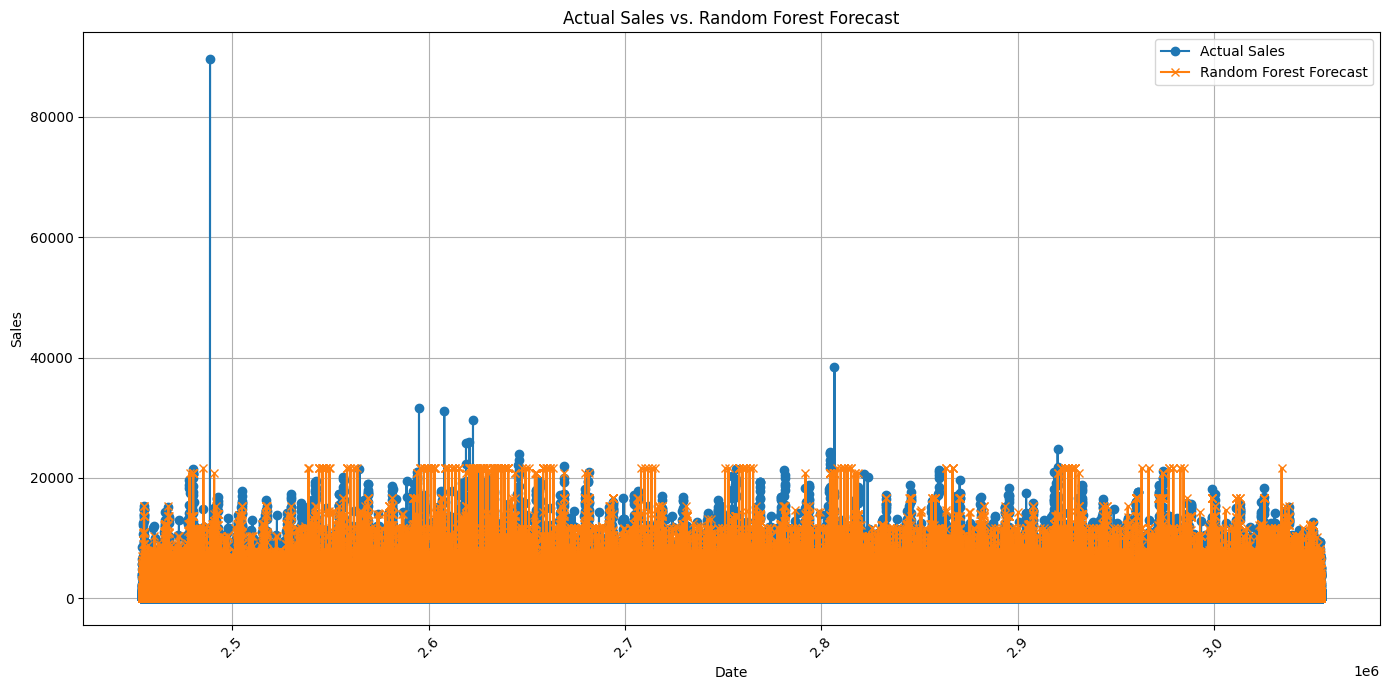

In [77]:
# Visualisation of Random Forest model.
plt.figure(figsize=(14,7))
plt.plot(y_val.index, y_val, label='Actual Sales', marker='o')
plt.plot(y_val.index, rf_preds, label='Random Forest Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual Sales vs. Random Forest Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# feature importance in the Random Forest model.
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)


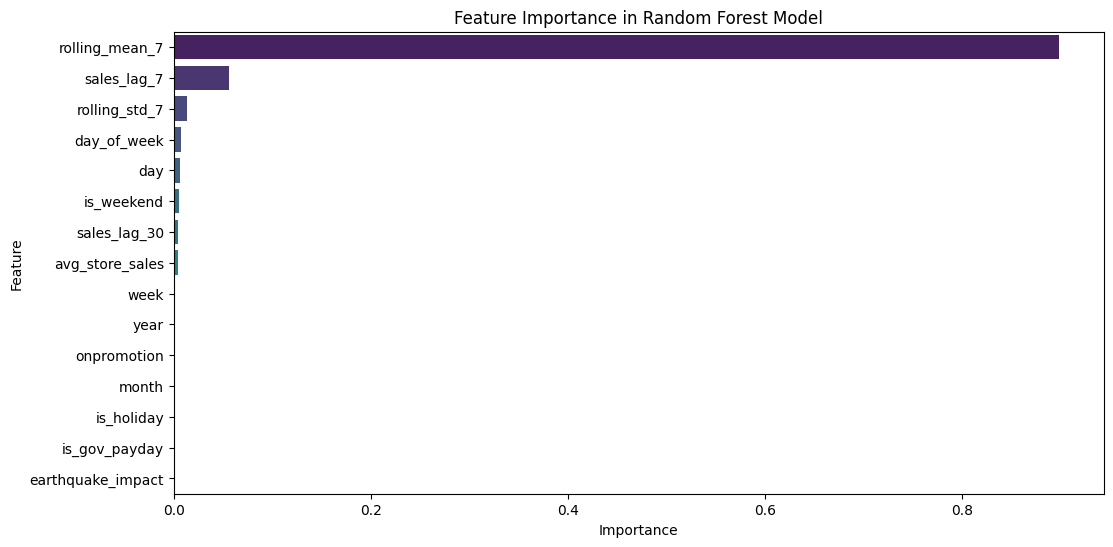

In [79]:
# visualisation of feature importance.
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### XGBRegressor Model.

In [80]:
# Use XGB model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators = 100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

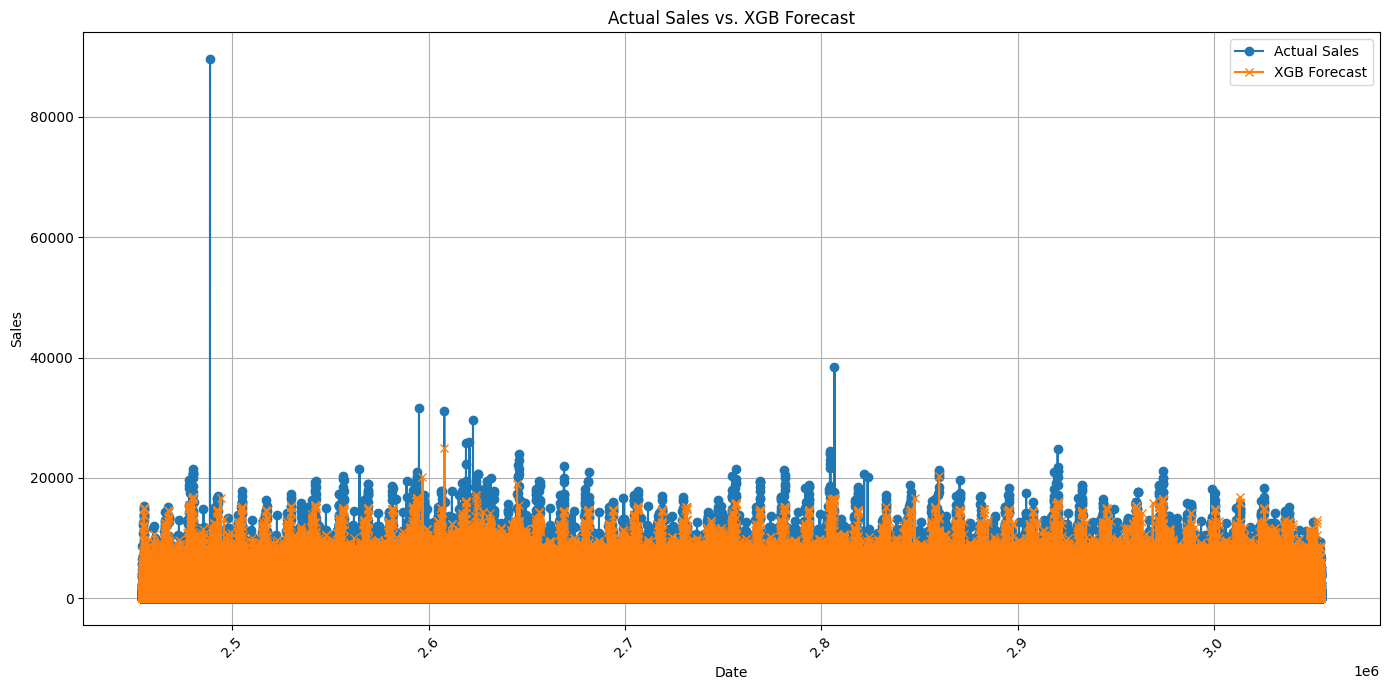

In [81]:
# Visualisation of XGB model.
plt.figure(figsize=(14,7))
plt.plot(y_val.index, y_val, label='Actual Sales', marker='o')
plt.plot(y_val.index, xgb_preds, label='XGB Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual Sales vs. XGB Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
# feature importance in the XGB model.
xgb_feature_importance = xgb_model.feature_importances_
xgb_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_feature_importance})
xgb_feature_importance_df = xgb_feature_importance_df.sort_values('Importance', ascending=False)


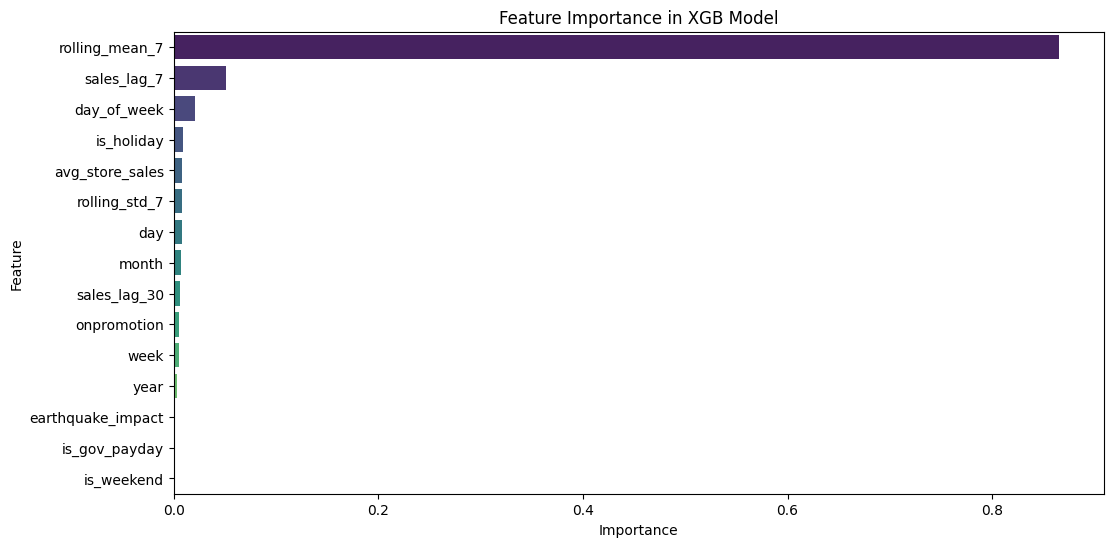

In [83]:
# plot the feature importance graph.
plt.figure(figsize=(12, 6))
sns.barplot(data=xgb_feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance in XGB Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Model Evaluation.

### Comparing the models based on basic metrics RMSE, MAPE, and R2 scores.

In [84]:
# define evaluation function.
def eval_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R2: {r2:.2f}")

In [85]:
# Print metrics
print("Model Evaluation metrics:")
print("-" * 40)
eval_model(y_val, arima_preds, "ARIMA")
eval_model(y_val, rf_preds, "Random Forest")
eval_model(y_val, xgb_preds, "XGBoost")

Model Evaluation metrics:
----------------------------------------
ARIMA - RMSE: 1427.44, MAPE: 5702293627806330880.00%, R2: -0.09
Random Forest - RMSE: 430.95, MAPE: 979404186955237760.00%, R2: 0.90
XGBoost - RMSE: 307.83, MAPE: 729270049363854848.00%, R2: 0.95


### Visual Inspection (Plot actual vs. predicted sales)

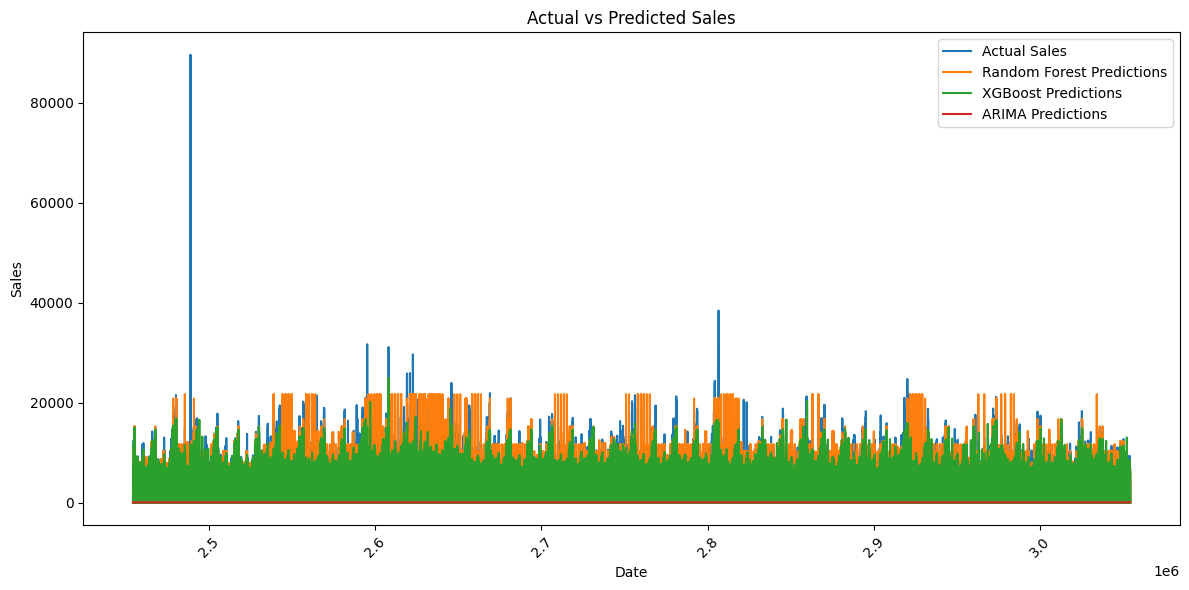

In [86]:
# Visualisation of predicted forecasting models
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_val.index, y=y_val, label='Actual Sales')
sns.lineplot(x=y_val.index, y=rf_preds, label='Random Forest Predictions')
sns.lineplot(x=y_val.index, y=xgb_preds, label='XGBoost Predictions')
sns.lineplot(x=y_val.index, y=arima_preds, label='ARIMA Predictions')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Conclusion
#### For a better forecast, we need to have lower RMSE, MAPE, and higher R2 scores.
#### Here out of all the models compared "XGBoost" model has the lowest RMSE and MAPE scores and the highest R2 score.
#### Hence it can be deployable but we can try and improve the model accuracy by improving the training sample size, and other hyper parameter tuning techniquiques.
#### LSTM , and Prophet models can also be tried for better accuracy. but due to low resources and time constraints I tried to model them on a single store data set.

------------------------------------------------------------------------------------------------------------------------------

### LSTM Model (Long short-term memory) for store 1.

In [87]:
# For low memory usage we can construct a LSTM based on the store 1 data.
store1_train = train[train['store_nbr'] == 1].sort_values('date').reset_index(drop=True)

# Use 'sales' as our univariate target variable.
sales = store1_train['sales'].values.reshape(-1, 1)

# Scale sales data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
sales_scaled = scaler.fit_transform(sales)

# Function to create sequences for LSTM model with look_back.
def create_sequences(data, look_back=7):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

# Create sequences with look_back=7.
look_back = 7
X, y = create_sequences(sales_scaled, look_back)

# Split the data into training and validation sets.
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build a minimal LSTM model
model = Sequential([
    LSTM(50, input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16,
                    validation_data=(X_test, y_test), verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform to get original sales scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.2f}")

Epoch 1/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0038 - val_loss: 0.0065
Epoch 2/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0038 - val_loss: 0.0064
Epoch 3/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0036 - val_loss: 0.0057
Epoch 4/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 5/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 6/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 7/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 8/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 9/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 10/10
2828/2828 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0021 - val_loss: 0.0035
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 536.21
MAPE: 96806592666856016.00
R² Score: 0.46


### Visualisation of model training actual vs forecast.

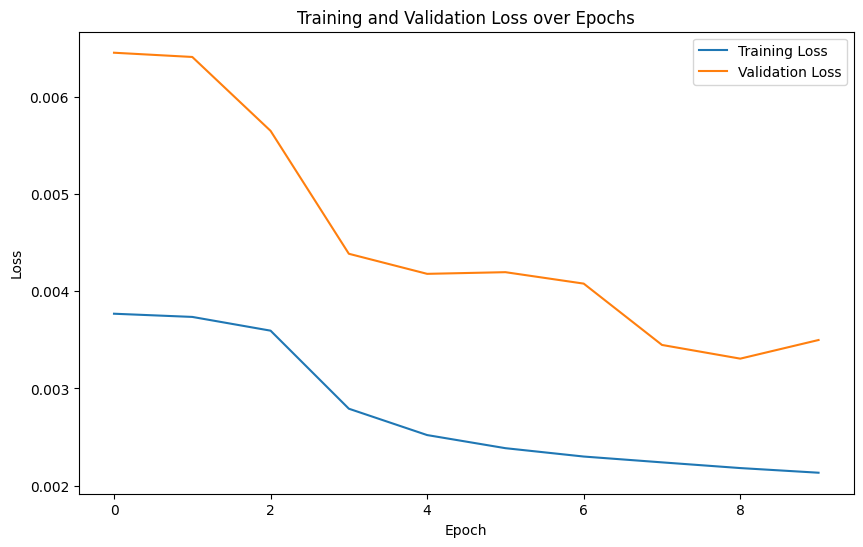

In [88]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

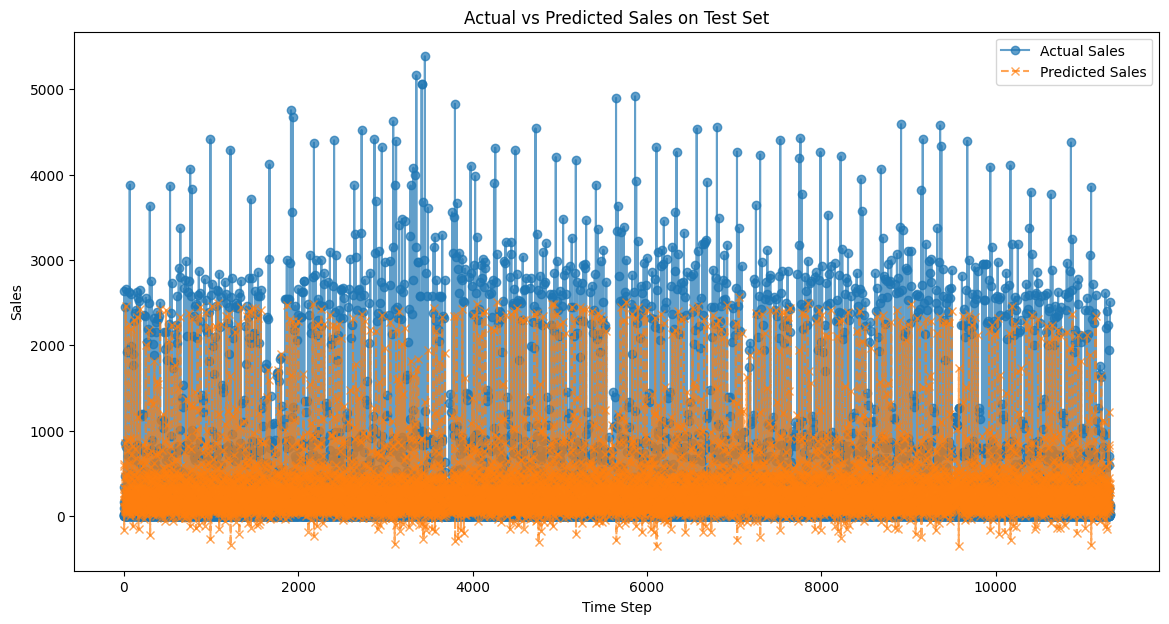

In [89]:
# Plot actual vs predicted sales for the test set
# Flatten the arrays if they are in 2D
y_test_flat = y_test_inv.flatten()
y_pred_flat = y_pred_inv.flatten()

plt.figure(figsize=(14, 7))
plt.plot(y_test_flat, label='Actual Sales', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred_flat, label='Predicted Sales', marker='x', linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Sales on Test Set')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Prophet Model for store 1.

In [90]:
# Filter data for a single store (store_nbr 1) and sort by date
store1_prophet = train[train['store_nbr'] == 1].sort_values('date').reset_index(drop=True)
Store1_prophet_sort = store1_prophet[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

# Split data by date (using 80% of the time period for training)
cutoff_index = int(len(Store1_prophet_sort) * 0.8)
train_prophet = Store1_prophet_sort.iloc[:cutoff_index].copy()
test_prophet = Store1_prophet_sort.iloc[cutoff_index:].copy()

# identify the training and test periods
print("Training period: {} to {}".format(train_prophet['ds'].min(), train_prophet['ds'].max()))
print("Test period: {} to {}".format(test_prophet['ds'].min(), test_prophet['ds'].max()))

# Initialize and fit the Prophet model on the training set
model = Prophet()
model.fit(train_prophet)

# Create a future dataframe covering the period of the test set.
n_periods = (test_prophet['ds'].max() - train_prophet['ds'].max()).days
future = model.make_future_dataframe(periods=n_periods, freq='D')

# Generate forecast
forecast = model.predict(future)

# Merge forecast with test set based on the date column 'ds' to ensure alignment
pred = forecast[['ds', 'yhat']].merge(test_prophet[['ds']], on='ds', how='inner')
actual = test_prophet.reset_index(drop=True)

# Check if predictions align with actual test dates
print("Number of test samples:", len(actual))
print("Number of predictions:", len(pred))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(actual['y'], pred['yhat']))
mape = mean_absolute_percentage_error(actual['y'], pred['yhat'])
r2 = r2_score(actual['y'], pred['yhat'])

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R² Score: {r2:.2f}")

Training period: 2013-01-01 00:00:00 to 2016-09-12 00:00:00
Test period: 2016-09-12 00:00:00 to 2017-08-15 00:00:00


21:13:19 - cmdstanpy - INFO - Chain [1] start processing
21:13:32 - cmdstanpy - INFO - Chain [1] done processing


Number of test samples: 11313
Number of predictions: 11313
RMSE: 728.51
MAPE: 158254820618800832.00
R² Score: 0.01


### Visualisation of model parameteres and forecast.

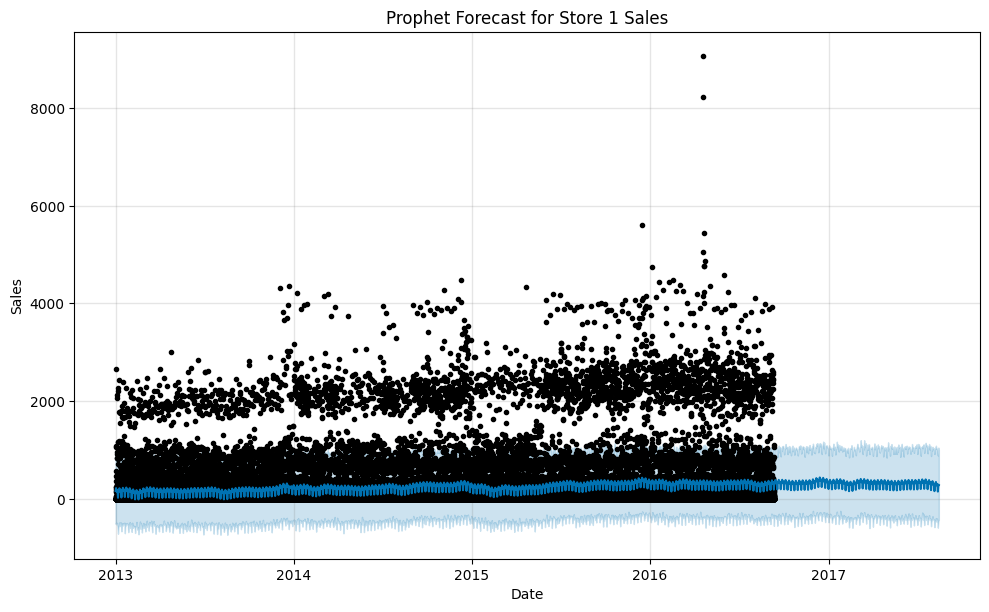

In [91]:
# Plot the Prophet forecast (includes uncertainty intervals)
fig1 = model.plot(forecast)
plt.title("Prophet Forecast for Store 1 Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

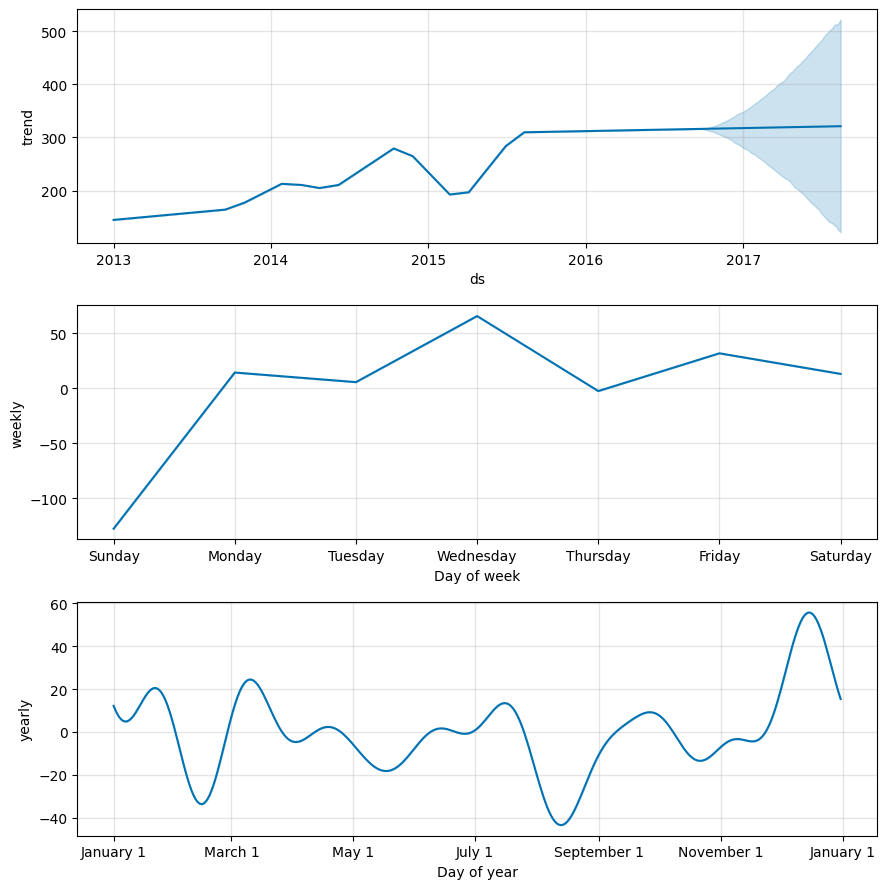

In [92]:
# Plot the forecast components (trend, weekly seasonality, etc.)
fig2 = model.plot_components(forecast)
plt.show()

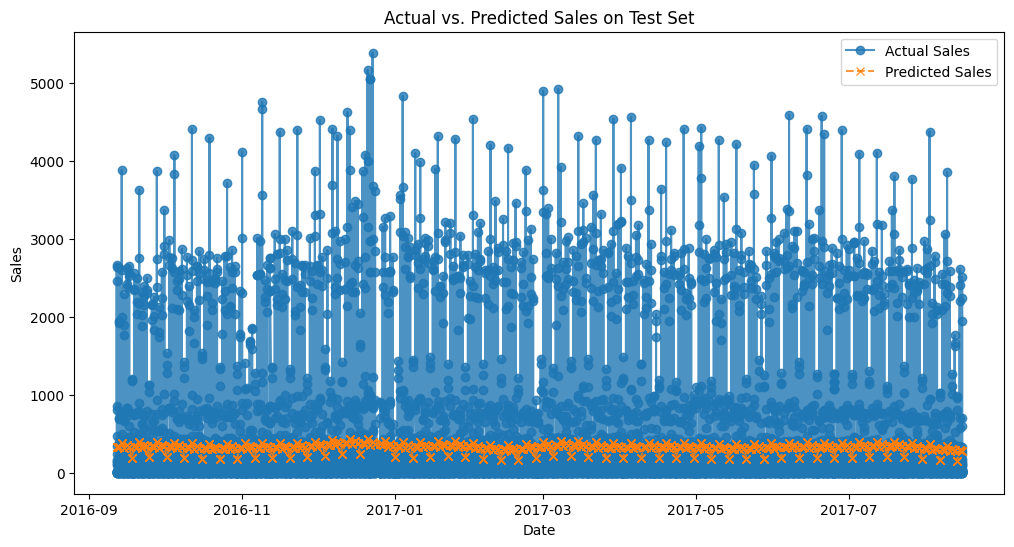

In [93]:
# Create a custom plot overlaying actual vs. predicted sales for the test period
plt.figure(figsize=(12, 6))
plt.plot(actual['ds'], actual['y'], label='Actual Sales', marker='o', linestyle='-', alpha=0.8)
plt.plot(pred['ds'], pred['yhat'], label='Predicted Sales', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs. Predicted Sales on Test Set')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()